## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

In [2]:
import os, sys
#current_dir = os.getcwd()
DATA_HOME_DIR =  '/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/'

## Create validation set and sample

In [6]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir results
%mkdir models
%mkdir valid
%mkdir -p test/unknown

/home/denys/projects/ml-models/kaggle/dog-breed-identification/data
mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘models’: File exists


In [1]:
from glob import glob
import numpy as np
import pandas as pd

In [8]:
%cd $DATA_HOME_DIR/train

/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/train


In [9]:
VALID_DATA_LEN = 1000

g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(VALID_DATA_LEN): os.rename(shuf[i], DATA_HOME_DIR + '/valid/' + shuf[i])

In [16]:
labels_df = pd.read_csv("../labels.csv")

def get_breed(id):
    return labels_df.loc[labels_df["id"] == id]["breed"].values[0]

In [14]:
def prepare_data_structure(dir):
    train_path = DATA_HOME_DIR + dir
    g = glob(train_path + '*.jpg')
    for i in range(len(g)):
        file_name = g[i][-36:]
        dir_path = train_path + get_breed(file_name[:-4])
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        os.rename(train_path + "/" + file_name, dir_path + "/" + file_name)

In [15]:
prepare_data_structure("train/")
prepare_data_structure("valid/")

0d6c6238a4cc499bb57fa0c10a15f8ad
547    dingo
Name: breed, dtype: object
209fae9c9a2ec63321399a9b14ae28ec
1317    briard
Name: breed, dtype: object
ef3dc6a3af2210c9cc59e2bbdc9e9ae1
9543    west_highland_white_terrier
Name: breed, dtype: object
8c6d252c208a9564a72522e6592b12d1
5563    miniature_pinscher
Name: breed, dtype: object
aadf0358c789a5b5aa558c66f580e92d
6804    dingo
Name: breed, dtype: object
41ea18e619cb6a3673ce86ea8e0f2f14
2663    afghan_hound
Name: breed, dtype: object
ed8fd9eef589a6fe4a0e74bf7ea77bd6
9476    giant_schnauzer
Name: breed, dtype: object
3c688d71041c32d4f5efb52c509f10bd
2428    brittany_spaniel
Name: breed, dtype: object
d198549ea46f9f624b71fcffbcbe8e31
8356    german_short-haired_pointer
Name: breed, dtype: object
013f8fdf6d638c7bb042f5f17e8a9fdc
48    tibetan_terrier
Name: breed, dtype: object
b9480efcc378fcc84c6e939dbfa59414
7402    clumber
Name: breed, dtype: object
41f92db830495f2811eedfd776dce08c
2668    eskimo_dog
Name: breed, dtype: object
607af117d6e5

af408dfdb162d16e74828ac11f784cd1
6991    irish_setter
Name: breed, dtype: object
fc7cefece70681db1b55887a4b02a901
10079    keeshond
Name: breed, dtype: object
01b6c2bd3053535a58d8de763cf06aa0
71    miniature_schnauzer
Name: breed, dtype: object
8009cbb471a6107109af3166c03b6e83
5056    entlebucher
Name: breed, dtype: object
1fa82619012d8693282ace6d05e81ccd
1275    yorkshire_terrier
Name: breed, dtype: object
f80ad50586c794ea8555e3bed23e0c0e
9860    otterhound
Name: breed, dtype: object
f3b343a1d0a394e5d29a74f31f9922c8
9683    appenzeller
Name: breed, dtype: object
fefb453e43ec5e840c323538261493bd
10180    lhasa
Name: breed, dtype: object
dd27b4e1da87a6db84d1aa08f908c95d
8825    staffordshire_bullterrier
Name: breed, dtype: object
4366ae84914916e5e60738e0d1d3846e
2741    airedale
Name: breed, dtype: object
1c0d38d23888da863dbb28b5db1cc4af
1125    sealyham_terrier
Name: breed, dtype: object
01680178ca6664294efb493a46014a82
58    irish_terrier
Name: breed, dtype: object
015b4aa50dd9b4a0d26

85ef8ce1e2e798ad6ce5289c42b9055b
5321    clumber
Name: breed, dtype: object
9adbe43816a43b4e4510c7ebdf88d1fc
6146    lakeland_terrier
Name: breed, dtype: object
b39551fc6a24b76d219c3244b587a2e2
7160    walker_hound
Name: breed, dtype: object
d793a68896bf50ec6b19adbf2770b450
8592    mexican_hairless
Name: breed, dtype: object
26f7854ae1cc8788a25488276f54b06f
1574    brittany_spaniel
Name: breed, dtype: object
771145b82a29f68c70e29f7bbb58797b
4749    curly-coated_retriever
Name: breed, dtype: object
28f7140259e0f9d36cd67cb3f194fe34
1651    groenendael
Name: breed, dtype: object
a0149e2a9b0584d29be0a68207899b9e
6353    tibetan_terrier
Name: breed, dtype: object
2b0beabe94af30c51d3d3149c4832c38
1739    bloodhound
Name: breed, dtype: object
917ce8504f2a5347de1686975842b4bf
5759    saint_bernard
Name: breed, dtype: object
6a835aa56954b3dee4730a9ab08cfda1
4269    west_highland_white_terrier
Name: breed, dtype: object
8a5349f4b15dddd7472b569e9cdd3f39
5483    english_foxhound
Name: breed, dtype

447fb3c3e90378c69e71208ff3ce8803
2786    golden_retriever
Name: breed, dtype: object
560100152f7c608aa8e5ae4e6321395e
3457    redbone
Name: breed, dtype: object
66c6f1d257f800de60c0d088561c44e9
4126    clumber
Name: breed, dtype: object
48b3e345543f3c0e79003f87ca1f0518
2943    welsh_springer_spaniel
Name: breed, dtype: object
5a17ae0a3a103de1451c47e466fab008
3627    irish_setter
Name: breed, dtype: object
b340dcf23d4edfcf93b00c400decb824
7144    irish_setter
Name: breed, dtype: object
6503d3800607b046fceaf85348c930d2
4058    curly-coated_retriever
Name: breed, dtype: object
c2b94313a6ba125f1b7839484e08ba00
7784    maltese_dog
Name: breed, dtype: object
a5e8b55e8a408c9e63bd2986b56b9911
6601    irish_terrier
Name: breed, dtype: object
abcb98b8f6840bd5563b037ba85a4d06
6844    pekinese
Name: breed, dtype: object
364bbe6fb891f50e904613581d6cf3ac
2170    chihuahua
Name: breed, dtype: object
eda5b27feb982dce425c1731a1174e1a
9480    irish_terrier
Name: breed, dtype: object
b851f6cbfd20d707f742

7684bc9005956e3fa3cbd7c8d4697e57
4727    miniature_schnauzer
Name: breed, dtype: object
dac080b6ac2c9d3013b3762e45296955
8711    bull_mastiff
Name: breed, dtype: object
b1e04e72134f93f445ebb10a1aa7c20f
7082    staffordshire_bullterrier
Name: breed, dtype: object
b4a8871365faccfa51e33217c4fd1291
7209    beagle
Name: breed, dtype: object
5353afdcaf0ad24196c1fdf1276ca644
3357    dhole
Name: breed, dtype: object
82ea470ddc6c9fbef9bf41be2cf85d00
5178    komondor
Name: breed, dtype: object
9bd6bfe9d0f21fbe059596962a49313f
6182    eskimo_dog
Name: breed, dtype: object
f706682a30021cc74cd9416dac25e943
9815    norwich_terrier
Name: breed, dtype: object
608daa34284981501bb9ad2443579a21
3891    curly-coated_retriever
Name: breed, dtype: object
8c96a702b0a8fc525956f780ec87a28d
5568    curly-coated_retriever
Name: breed, dtype: object
3f674c39cfc8fc3f421b3b8e69143b70
2548    airedale
Name: breed, dtype: object
481c63efebeaf9c39d0f506bf417f80a
2909    irish_wolfhound
Name: breed, dtype: object
ecaec

7a3570346994f3c37c45f0acae101551
4874    scotch_terrier
Name: breed, dtype: object
e06773bd0666b3b9597b93a54e302c55
8938    basset
Name: breed, dtype: object
61cf8e700e9414a071a03ebc6abe397d
3940    black-and-tan_coonhound
Name: breed, dtype: object
f6c6e52ad7508381c9b545e7e4f77d8d
9807    pomeranian
Name: breed, dtype: object
51c09b0295e0137021db430c38308e8b
3288    kelpie
Name: breed, dtype: object
6718d0b68e2ec8d701facf67464134b1
4145    wire-haired_fox_terrier
Name: breed, dtype: object
b3ce89788191e0f62e14820abd176628
7174    norwegian_elkhound
Name: breed, dtype: object
46face412f869902099b081490f1cd80
2874    old_english_sheepdog
Name: breed, dtype: object
4e6127b6afe0116be8c2eb59decf6a02
3178    french_bulldog
Name: breed, dtype: object
d482fb5576279496d6f8d72bf6b93d9f
8466    scottish_deerhound
Name: breed, dtype: object
937af3a67d2b55afb480c7c624f470d6
5839    tibetan_mastiff
Name: breed, dtype: object
eb5635af7d2f315b0f256aee4f41524e
9380    cardigan
Name: breed, dtype: obje

Name: breed, dtype: object
f7c22e91e22c5a97abb2b7d9bab98809
9848    african_hunting_dog
Name: breed, dtype: object
ebb8c99c50ca5b48e010f0bda9a62c85
9395    great_pyrenees
Name: breed, dtype: object
a5daf7e90363737374840aee6cbf6ab5
6598    dandie_dinmont
Name: breed, dtype: object
bca1feecf7cb3a75340527fe79152a3f
7522    west_highland_white_terrier
Name: breed, dtype: object
748256d6f5781e0404b63b6e6e6a1dc7
4657    french_bulldog
Name: breed, dtype: object
2fc7502eeb040b3a30ef455fae1dada0
1938    basenji
Name: breed, dtype: object
da82351431ac8992359ffca87bca053d
8701    scottish_deerhound
Name: breed, dtype: object
4ca6732ea8c9a354d28b5e8fc71385e4
3102    affenpinscher
Name: breed, dtype: object
a42ab2df772522cbc2d81d7d7541f670
6524    irish_terrier
Name: breed, dtype: object
3b6e352b98a028684231b26e0b1398f4
2390    irish_terrier
Name: breed, dtype: object
17193d29b9833d783133f4b13f12f513
946    english_foxhound
Name: breed, dtype: object
d1676f45ee40b1c585ddc56b2a63c402
8351    lakela

Name: breed, dtype: object
ec53887c5887ec7be3693459ad3ba4ed
9425    maltese_dog
Name: breed, dtype: object
091306dd0d110a677fe0de1ad066f160
375    sealyham_terrier
Name: breed, dtype: object
f8d6ec246da32576653776342d52cb69
9905    dandie_dinmont
Name: breed, dtype: object
a0f900fe444c2c09f03d5170960e2825
6383    pug
Name: breed, dtype: object
09a1ea62ffa4b9389c03162bb0b0b572
403    saint_bernard
Name: breed, dtype: object
3755a414ab32ec712f2058cb6dc47d04
2204    keeshond
Name: breed, dtype: object
e734678e0c18e103c41023e11b92e012
9196    affenpinscher
Name: breed, dtype: object
538921b32a385b9e4cd5ce4dbb0ba462
3368    german_shepherd
Name: breed, dtype: object
062131c6c38a1e485091c8c3329d9638
262    shih-tzu
Name: breed, dtype: object
c93de7c42883d7819fbfc95914ba6493
8051    border_terrier
Name: breed, dtype: object
3976ced5b536c12b5f9fead049089575
2305    pomeranian
Name: breed, dtype: object
fd0f827a0d0ad9a2ff60ddf30e5d50be
10106    saint_bernard
Name: breed, dtype: object
bbc6ea23d

4cb48a54b94e4c7dcf9798f7cc7f5a92
3106    affenpinscher
Name: breed, dtype: object
173493daaae8804e5a837ddfe2e21c50
952    lakeland_terrier
Name: breed, dtype: object
d40d6d4e0f03bf31449179b106ac009d
8440    norwegian_elkhound
Name: breed, dtype: object
f7886847e4058293245db300e17928fc
9837    basenji
Name: breed, dtype: object
a6230f82a77ecf899cdcc1ba62073084
6606    doberman
Name: breed, dtype: object
044efbf8ab3e7195b8ea3c92ef0d48df
185    black-and-tan_coonhound
Name: breed, dtype: object
61664c4d0be465a085b11a1cd36be3b1
3921    brittany_spaniel
Name: breed, dtype: object
1465759436b4acd2748dd50108b90ca9
830    lhasa
Name: breed, dtype: object
94c4d59a7e93326c11db4bb1d0ca8a23
5897    papillon
Name: breed, dtype: object
bf121d8d8af31728d8882d30242289e3
7631    irish_terrier
Name: breed, dtype: object
cd047489ca9d316cc15fe8b3c52d3090
8201    english_foxhound
Name: breed, dtype: object
48352a6189e2d6368b794bd7bcbabb0d
2918    shih-tzu
Name: breed, dtype: object
a32faea2f67d4949761454e0

2a290eb7b2cf9dd735935388c5ffa6f1
1698    pembroke
Name: breed, dtype: object
a6418161b67df372016f510bfd71ddb6
6613    cairn
Name: breed, dtype: object
2504c258bacb5fb0fd35c0f46330d6da
1498    irish_terrier
Name: breed, dtype: object
564f6459771be13539c5caeec1258fde
3465    cocker_spaniel
Name: breed, dtype: object
78b7197ade3d5e29873a7ea27adc760c
4811    rhodesian_ridgeback
Name: breed, dtype: object
5cb8e8855145375221015c02fe21b273
3725    affenpinscher
Name: breed, dtype: object
ae321243a4dfba310868a20dfaba514b
6945    scotch_terrier
Name: breed, dtype: object
76a366813f6d0182709d8fa154fc24b2
4732    yorkshire_terrier
Name: breed, dtype: object
c56d360b7601ce3882d5016abdc83157
7887    weimaraner
Name: breed, dtype: object
2e3ef941c9d921bf18607e5930f548ee
1872    mexican_hairless
Name: breed, dtype: object
3fc2dde0964144cd07747c740469e60b
2561    great_pyrenees
Name: breed, dtype: object
7c5efc5d9f30d9ca94d9234d2b85b1eb
4949    schipperke
Name: breed, dtype: object
42729b9128f65dc9be8

290a83cd8331cfe96a1846f5e1977b55
1652    basset
Name: breed, dtype: object
c1f782c71d46690a156d8bbb6c5dca22
7743    kuvasz
Name: breed, dtype: object
cd2365170b2191c7a5df0c9531f2af70
8209    entlebucher
Name: breed, dtype: object
26a4f5afd06a0fceea3dcb095fb47e80
1564    french_bulldog
Name: breed, dtype: object
e9da345a17d3e21041214e6cef9556a4
9316    great_pyrenees
Name: breed, dtype: object
e47a26a0b4510b25250f654577207ed3
9084    samoyed
Name: breed, dtype: object
03da788cc7e5c111575daf04e7e3910c
160    toy_poodle
Name: breed, dtype: object
93a364a9da700ae22e87f9666b5365dc
5853    collie
Name: breed, dtype: object
36c1add2344fd41b7a73e06b61727a64
2186    otterhound
Name: breed, dtype: object
3ea91cbb825208d186e94a0bb633ee75
2514    miniature_pinscher
Name: breed, dtype: object
547231618deb73591ff006835eb13765
3397    pomeranian
Name: breed, dtype: object
3c8b026a371181f328fb94f5c133b21e
2434    samoyed
Name: breed, dtype: object
e5757684859b44aa875efd4d67661399
9130    keeshond
Name

Name: breed, dtype: object
795711c5b083e14307d5e5769402af8d
4835    bouvier_des_flandres
Name: breed, dtype: object
64684514366ddd73a109ad635f6f0148
4037    newfoundland
Name: breed, dtype: object
7332891f534fdfc75dd133048af1d562
4606    beagle
Name: breed, dtype: object
b9757ae6aae924b0b5771d9dcd7590ca
7408    samoyed
Name: breed, dtype: object
160f87a50f4c3c80752872faa80e4699
902    cardigan
Name: breed, dtype: object
fe76cbb5f172387f6a5b72739852d608
10163    scotch_terrier
Name: breed, dtype: object
d248481e21f44ffe66f969af4206b45d
8383    toy_terrier
Name: breed, dtype: object
e387ac130247a8a48e1a136d9a4e013c
9055    australian_terrier
Name: breed, dtype: object
6985868ae61fe1bf70df21daab794219
4239    pomeranian
Name: breed, dtype: object
47f02213cbfdc596826e2c24adeb97ec
2903    cardigan
Name: breed, dtype: object
978a9eee19b794afb59da56af20e8714
6007    blenheim_spaniel
Name: breed, dtype: object
cf16389be0d418812e47ae7694b441b4
8271    newfoundland
Name: breed, dtype: object
14e

1be0f5da239e9c76a8b3693b2ff8c67f
1118    rottweiler
Name: breed, dtype: object
52c9ab0f6d9f27daaf3641f86c019cae
3331    toy_terrier
Name: breed, dtype: object
a6eb4c19bbe8efd5d4fc9ac41e0cba4b
6644    malamute
Name: breed, dtype: object
3759477c2764d4e01d44d5be03b917f6
2205    bluetick
Name: breed, dtype: object
b88d4e63f9151739573ed538c8dc999e
7363    tibetan_terrier
Name: breed, dtype: object
806cbcc0362d78eabe9930ccd9b1c184
5069    norfolk_terrier
Name: breed, dtype: object
2ebf9f6ed8dbe3c348b809987f8e0c02
1901    curly-coated_retriever
Name: breed, dtype: object
43dd4c3084d3f35b4ae3268cb0199696
2757    malinois
Name: breed, dtype: object
07b5288a0bb8b9cf1a42d281a9451e51
319    irish_water_spaniel
Name: breed, dtype: object
4bab292d36e33a1479ff6b13d595966a
3070    pembroke
Name: breed, dtype: object
a07e99186fe1459309d6b81c971313f7
6367    kerry_blue_terrier
Name: breed, dtype: object
edb50bbbbf53fb184cbc04f21dd97b81
9485    scottish_deerhound
Name: breed, dtype: object
3da1a4e6e24a1

5775    great_dane
Name: breed, dtype: object
c34297e6db453a12e69c2ff3a107125e
7807    cairn
Name: breed, dtype: object
6001fc9133e426ecf5250b50414534f9
3869    entlebucher
Name: breed, dtype: object
f234c1a8c84a833c77a7774da09cbb1a
9626    kerry_blue_terrier
Name: breed, dtype: object
f71e0bbcb7b9d348986393612e1b6800
9819    shih-tzu
Name: breed, dtype: object
09ea184490e5da33eb3d851ee6361941
413    redbone
Name: breed, dtype: object
afadd4327b01b62e6e98289c8f72e1ee
7007    pug
Name: breed, dtype: object
302e4507ef9c5ba2c0b26ab890cd250c
1956    tibetan_mastiff
Name: breed, dtype: object
ca862f2b2d77f940c2a934acca05dfe1
8107    kuvasz
Name: breed, dtype: object
54f801ce3b48bb48b6213d697ad22683
3415    great_pyrenees
Name: breed, dtype: object
77f1a9085d57f10fcf733e45f565b287
4779    staffordshire_bullterrier
Name: breed, dtype: object
83fad0718581a696132c96c166472627
5230    pug
Name: breed, dtype: object
5431316ec1ca840d0a7fbb7e7d15edbd
3391    tibetan_mastiff
Name: breed, dtype: obje

cbd8e6c8f98e12a8b336ecedfd874707
8154    afghan_hound
Name: breed, dtype: object
d554743c028b0ec7d91739cd47e3f33f
8496    redbone
Name: breed, dtype: object
491541eb0f939e99935d805592b6a324
2957    shetland_sheepdog
Name: breed, dtype: object
daa59e97cb75d22b9691d48bdee59f53
8703    samoyed
Name: breed, dtype: object
65a840a987d9b5e7af83013e8b38f5ca
4084    entlebucher
Name: breed, dtype: object
f3f295d33149977b1d67b8a3b6484ea7
9699    mexican_hairless
Name: breed, dtype: object
12fbfefaae57137c745f16b0cf11b84d
765    otterhound
Name: breed, dtype: object
266115adee245e31c3b8ee4860db376f
1552    shih-tzu
Name: breed, dtype: object
ac50e3733b58fdecc1eaba7ee8efdb84
6861    entlebucher
Name: breed, dtype: object
ebc378abeb610e6d4f2a8ad0d731ccfb
9397    english_springer
Name: breed, dtype: object
376e1408f5523aa335c058c843eec857
2209    blenheim_spaniel
Name: breed, dtype: object
71b9314a8d3d19ce383dba9e5f81da71
4551    kelpie
Name: breed, dtype: object
63d1b332f937aa0de02a3d714c31fd8b
400

2cbde3740c0b20a8324a150aa966a3ef
1810    dingo
Name: breed, dtype: object
a56fc127e3c0b271e37873d3ad6c9e59
6575    rhodesian_ridgeback
Name: breed, dtype: object
d6574a7c2c804a33cf3d29d917923349
8537    welsh_springer_spaniel
Name: breed, dtype: object
b141511bd1e9f3010faa8582dd85303a
7062    scotch_terrier
Name: breed, dtype: object
c2a48517799dedbde16fa299a88e8e13
7780    rhodesian_ridgeback
Name: breed, dtype: object
6aa03ec0e86f5c0872643b7146bfcd52
4274    groenendael
Name: breed, dtype: object
549b9df75ad46e33bddfae7628609319
3403    irish_wolfhound
Name: breed, dtype: object
05fbe54802ffb6d6256abb93381f5cf4
256    appenzeller
Name: breed, dtype: object
758d370b554cd5f454810d8983f87d55
4689    saluki
Name: breed, dtype: object
b8e233e679db8a5e7bcdab32c3d891ec
7382    italian_greyhound
Name: breed, dtype: object
736e858993ff23597502d4483fa62552
4618    cocker_spaniel
Name: breed, dtype: object
7b3105053d887c2098186d37399f7d32
4909    labrador_retriever
Name: breed, dtype: object
58

Name: breed, dtype: object
02f07e7e51662336a9d8c775a4eac5f4
124    miniature_schnauzer
Name: breed, dtype: object
2cf16ed82bc025e5a2331adac0b5dff8
1818    dhole
Name: breed, dtype: object
7408e8f78e6b1e7372010d145c7f7684
4644    old_english_sheepdog
Name: breed, dtype: object
eae07088a41c3d064b7d099b2fe63f11
9366    german_shepherd
Name: breed, dtype: object
fdccec2dc716306a12b773e7689887c0
10138    staffordshire_bullterrier
Name: breed, dtype: object
a1d4504294f8435423c56b96c4a76c18
6415    maltese_dog
Name: breed, dtype: object
170dba137a3990b225bdf19074b97023
943    scotch_terrier
Name: breed, dtype: object
30bfb415b8dc2a559ebbc259dbd6774b
1973    mexican_hairless
Name: breed, dtype: object
28bdfc1f5bb2c5e4794287b4c31cdf58
1645    leonberg
Name: breed, dtype: object
cf9628b5959c97e2be6a63e1e4335c24
8289    black-and-tan_coonhound
Name: breed, dtype: object
2b4e24996bd70174a4ecb6990a3d8204
1749    kerry_blue_terrier
Name: breed, dtype: object
4d49a0f1dbd0d2a80bbfcfd2d55a8936
3123    

58a7bcb4d05eaad860c3c1ae40700991
3564    pekinese
Name: breed, dtype: object
dfc12676704c8931010ff087e117d2f2
8915    redbone
Name: breed, dtype: object
278b69e68354513d1dba33be8bfbe1eb
1602    great_dane
Name: breed, dtype: object
d00642800e4ca6d84887a93e3430ae21
8310    chow
Name: breed, dtype: object
973156751af162e836c62bf2634d0220
5995    schipperke
Name: breed, dtype: object
cc4e63a104a2466da58a5f81550c37a4
8170    border_collie
Name: breed, dtype: object
e224c29118a187dccba77b4aaa355767
9005    collie
Name: breed, dtype: object
f6b08ab15d3448bcfa29aa59a552a742
9801    blenheim_spaniel
Name: breed, dtype: object
b5eaed19ce0231fc6157d6e8ac6239a2
7261    american_staffordshire_terrier
Name: breed, dtype: object
9215151844a0caedca69036cc1f574fe
5783    yorkshire_terrier
Name: breed, dtype: object
68a848cd380f56ec30952f422aa43e67
4205    siberian_husky
Name: breed, dtype: object
1dc44c282163994a08cc05a9c082f960
1197    west_highland_white_terrier
Name: breed, dtype: object
00290d3e1f

791    toy_terrier
Name: breed, dtype: object
976982b85d3f8c7b7297ffbaf8a78d55
6002    basset
Name: breed, dtype: object
cf2ab1c0c1009cceb951ca7d74bf13ca
8276    greater_swiss_mountain_dog
Name: breed, dtype: object
a2e01339b8f644a81cf73c0506193d25
6469    pomeranian
Name: breed, dtype: object
5bfd9576067a577da2cc278db7aae2e7
3686    bernese_mountain_dog
Name: breed, dtype: object
c24c3298ec501f8f7960ea76fdd317e9
7763    whippet
Name: breed, dtype: object
8085807e84c38a6f3a47743d340a91c3
5072    miniature_poodle
Name: breed, dtype: object
65db995e6d49efde1c8c5b895612c917
4094    pembroke
Name: breed, dtype: object
a7ce55dc85d2f4dbf62a4ffa82bf5df4
6686    english_setter
Name: breed, dtype: object
506152fbae239e14437811aa1f8dffec
3241    komondor
Name: breed, dtype: object
159d07f089673cd225f3a47d08ee772f
887    shih-tzu
Name: breed, dtype: object
0eb297c3d5f6cc93371f02f4ed35879c
602    cocker_spaniel
Name: breed, dtype: object
6c08d6132ebff659700cfc1b1c36cf50
4329    mexican_hairless
Na

1262    norwich_terrier
Name: breed, dtype: object
57942abef42726bb588e90abb5a6c6df
3516    weimaraner
Name: breed, dtype: object
88a9c4a74b1663c9b30ab62e3573ee75
5418    saluki
Name: breed, dtype: object
b82bc22d0ca3d81abafe53f12994d203
7348    sussex_spaniel
Name: breed, dtype: object
07b46335006fbbe0328aeb8213b874ce
318    curly-coated_retriever
Name: breed, dtype: object
4786ca40de4d33cfebda53968ca10ed4
2887    kuvasz
Name: breed, dtype: object
1b507c0901420f8aa4e8d1fea74a1372
1098    appenzeller
Name: breed, dtype: object
9a1f6626718348e63497ed0279d1dd6f
6111    leonberg
Name: breed, dtype: object
ada32a5a413db0763e807e86562f2695
6919    kuvasz
Name: breed, dtype: object
13267e83358116ad51bebdb1be3d0a8e
776    norfolk_terrier
Name: breed, dtype: object
5e8badb21ba551d4952a53c3960820b4
3822    otterhound
Name: breed, dtype: object
d110e189aff527674e08285e7ff86508
8338    keeshond
Name: breed, dtype: object
809b278f52ffd25f92740121ab913c3c
5075    standard_schnauzer
Name: breed, dty

d62be3aa1b627562ab1b85ce73f9fede
8529    boston_bull
Name: breed, dtype: object
7037652031c91f0b1d77089a1a6f981c
4492    black-and-tan_coonhound
Name: breed, dtype: object
69b282f3d9e81dba018b130b9eb2f3f2
4245    great_pyrenees
Name: breed, dtype: object
fcc9c872e76f097b8fd02b56760e7d48
10093    chesapeake_bay_retriever
Name: breed, dtype: object
5c79f8b596036c75fbc266289e4cc46c
3713    miniature_poodle
Name: breed, dtype: object
4d6c2eb3cf393af1601751a39647a78b
3131    dandie_dinmont
Name: breed, dtype: object
b65a39808830bf4c7ac7a2144f17161c
7282    border_terrier
Name: breed, dtype: object
3dff9244af2b9668a99c01f053b4d682
2487    lakeland_terrier
Name: breed, dtype: object
2637cc0c82e54086454cd271e2dcb61a
1545    italian_greyhound
Name: breed, dtype: object
e97e598576bbc9adf772f244870d4c7b
9300    leonberg
Name: breed, dtype: object
e21bbd2082fe9e256d856c9482aaac8c
9003    norwich_terrier
Name: breed, dtype: object
20f44e34fa743c7b6bcbf960bd7ac4d1
1338    komondor
Name: breed, dtype

e0417404576aa3117ab1a0c646743ed9
8932    tibetan_mastiff
Name: breed, dtype: object
987a026f2789da6e4a88cba40f4347e3
6037    german_shepherd
Name: breed, dtype: object
636aa6a1709f0a15664ce15d0fb70128
4004    shih-tzu
Name: breed, dtype: object
bd4bf652ce079538e6bc3de2612c1f03
7546    siberian_husky
Name: breed, dtype: object
953aad8d1b43596857b4b558804e751b
5912    german_shepherd
Name: breed, dtype: object
770c67d2d1c05302c985a8fe57c24f0f
4746    black-and-tan_coonhound
Name: breed, dtype: object
955fdc8f29b6b78c8888d0dfdd1c6a8d
5918    mexican_hairless
Name: breed, dtype: object
3a5ee5179351ec35c761ca460a6ffa20
2348    pomeranian
Name: breed, dtype: object
f28c40401e84e41f5aa4c60fea02a575
9636    yorkshire_terrier
Name: breed, dtype: object
a5545758fa85ed04ac848736e0eea7c0
6567    irish_wolfhound
Name: breed, dtype: object
d9c2cee7a77e1415dc97042e2c5458de
8677    beagle
Name: breed, dtype: object
e237f2c2da59abcb4d622106db8eef11
9009    leonberg
Name: breed, dtype: object
96139f2579

Name: breed, dtype: object
def4b391140f0633501190070ffd81e5
8894    cardigan
Name: breed, dtype: object
7e51be6584255a09aad57cc33e83f68b
4999    bernese_mountain_dog
Name: breed, dtype: object
990103331becc3d72956ba681d15e9bd
6057    mexican_hairless
Name: breed, dtype: object
f3afd4f69038b249042cd481f0b5813a
9682    siberian_husky
Name: breed, dtype: object
6147a05d911e17196d026a88a22c1906
3917    kerry_blue_terrier
Name: breed, dtype: object
c5cb2d2a9038b1181c7820ef05e838db
7911    tibetan_terrier
Name: breed, dtype: object
88f1fbdc15e7da1c28dfaa6b8cc01ac7
5426    dhole
Name: breed, dtype: object
25c22dead9fb1bf09d3984b2e6ebda43
1527    australian_terrier
Name: breed, dtype: object
10ce268c0affd428a49ada5a79fe9ca8
687    welsh_springer_spaniel
Name: breed, dtype: object
1c260556d4aa1a18f7b50a78689c92e6
1131    cardigan
Name: breed, dtype: object
565a2c3d7cb1a69c98630a7a09c529d4
3466    irish_water_spaniel
Name: breed, dtype: object
39e5840940279dc733267c3f246d9fd8
2323    weimaraner


Name: breed, dtype: object
7887ba5a0f253ea6b2e35201e5890655
4801    basenji
Name: breed, dtype: object
a198dfcff6e7b12eb4427dbdfe74349e
6408    sealyham_terrier
Name: breed, dtype: object
62d8924776e3a6842ab24f86fe866677
3979    labrador_retriever
Name: breed, dtype: object
1dba10683484b98ec59cbd5c998a0dad
1193    kuvasz
Name: breed, dtype: object
4b71f97031a0e5e0a4056fda372c1ba4
3061    miniature_pinscher
Name: breed, dtype: object
748edf024aa0ca6493917ece530b65a1
4660    airedale
Name: breed, dtype: object
ddcaf8e4f88b5c86a622cd62cfadfd5f
8844    german_shepherd
Name: breed, dtype: object
fb8c009186d200c2f49173d89f4a4a80
10029    sealyham_terrier
Name: breed, dtype: object
a3b7269c99889adde5b102ef461583bd
6500    lhasa
Name: breed, dtype: object
2c64e362c9aa29450082291264dcba29
1791    flat-coated_retriever
Name: breed, dtype: object
cc761b9fd55bdd6ab132b44a9b77a7da
8171    basenji
Name: breed, dtype: object
44a63eaceb7900974bc49d91b303a698
2796    keeshond
Name: breed, dtype: object

6b1288c9e5e983e77b84b95cfb11823b
4296    toy_terrier
Name: breed, dtype: object
16265434d841173019be215bea5d8097
904    saint_bernard
Name: breed, dtype: object
9fb14d359862987b31fee92145566e70
6330    malamute
Name: breed, dtype: object
f831a464cc42602094575fbb18ff1143
9873    kerry_blue_terrier
Name: breed, dtype: object
146c8ed2e65ed9e04d8302bf1d96815a
834    entlebucher
Name: breed, dtype: object
4db5e936fae9ba70ecb7e65605ba316b
3147    african_hunting_dog
Name: breed, dtype: object
72cd5b0c4da39b4499cf34f2c7a94f99
4594    chihuahua
Name: breed, dtype: object
a18a913cb80fdd9aec49672d08a297ea
6404    border_terrier
Name: breed, dtype: object
31af3732eda329b4d34c91d5a4fc69bf
2003    dhole
Name: breed, dtype: object
263a1b1fa0cafa212f6c34c7bf693b57
1546    affenpinscher
Name: breed, dtype: object
d26227912cf7189f6974908b19e0445f
8386    mexican_hairless
Name: breed, dtype: object
0db44ddb42bf1f97de987abe2bf01839
555    entlebucher
Name: breed, dtype: object
38d6bc0651588a0a04480b91893

2f7537cddd67e8464b394a765a05302d
1922    beagle
Name: breed, dtype: object
39c678ffdaee17e856ee93ec7d4644e6
2318    old_english_sheepdog
Name: breed, dtype: object
fbd70c8820a6fbcd21242284baa8ba27
10045    shetland_sheepdog
Name: breed, dtype: object
2b3c174dd8afc9bfdf4bd9cb3d4a0fad
1744    gordon_setter
Name: breed, dtype: object
f0216b542b2feaf7fea3412ce949536e
9571    schipperke
Name: breed, dtype: object
422b044a1bb57ca2d342ef53ca248238
2677    yorkshire_terrier
Name: breed, dtype: object
b4e20187a9b91d20f7e55615eb710785
7217    kelpie
Name: breed, dtype: object
016bcdb05e2d0e0878877df21b8c3cff
60    german_shepherd
Name: breed, dtype: object
61e259f889548a4cfd3ffc5258de2a60
3942    boxer
Name: breed, dtype: object
2e9be023f054bd4139ea30d699008be9
1889    basenji
Name: breed, dtype: object
04dea47b883acca9bd57c7ea2930524f
211    old_english_sheepdog
Name: breed, dtype: object
c9f66277a7804111d9491019cb3ec2ab
8081    flat-coated_retriever
Name: breed, dtype: object
74be31cddf2a8d320

412b82b8d22d227bd6938aa7884ac56b
2631    tibetan_mastiff
Name: breed, dtype: object
8410ced9ebc1759a7ebce5c42bfb5222
5237    irish_wolfhound
Name: breed, dtype: object
e1b04d497388246d0305c01f8d01fa1a
8985    standard_schnauzer
Name: breed, dtype: object
4d6f99b3534a4064f83b2dbba4a297a2
3132    soft-coated_wheaten_terrier
Name: breed, dtype: object
9a3e73ec5c6f18eec87d936cf73dbcdc
6119    miniature_poodle
Name: breed, dtype: object
24bfe78a765d02f011ac80c34bbdd7c3
1483    chow
Name: breed, dtype: object
505420c321e1e6c77bcaa3e3bb7ad7b7
3240    great_pyrenees
Name: breed, dtype: object
13863e32053e9735b55ba975ecd58cfd
787    malamute
Name: breed, dtype: object
18a44f4dc15b555f67e0e9f1b7aa0613
998    tibetan_mastiff
Name: breed, dtype: object
d6fbd70900969f939deaa4f101408858
8563    basset
Name: breed, dtype: object
7cd55fe61c967313bfca8ead6bb94580
4962    bull_mastiff
Name: breed, dtype: object
7ada315f86155f8f94a63af3657a4986
4898    great_pyrenees
Name: breed, dtype: object
d8785cb92c

8510    toy_poodle
Name: breed, dtype: object
6421c5d038254801f8bea318e2b52817
4023    dingo
Name: breed, dtype: object
a2cf649e9d08ee2289ca1dd90e089cc3
6466    miniature_pinscher
Name: breed, dtype: object
201fe1c7b5c0c513c42d1a1ba350d4df
1291    french_bulldog
Name: breed, dtype: object
720f6fa34b0eb27d998eb879bee468b7
4560    pug
Name: breed, dtype: object
92a8d330ae081b4514acb5c28fc3c2c2
5805    bull_mastiff
Name: breed, dtype: object
11b60d8d86f14a601ca290909a17cbc6
719    affenpinscher
Name: breed, dtype: object
bf904a3e0ad73be75221a5fc271bece6
7649    boston_bull
Name: breed, dtype: object
9e7ceb9ae79ad60616a6bdfbbc92c963
6277    irish_water_spaniel
Name: breed, dtype: object
1cb81d1bbaa7d0c550281979b853491c
1153    lhasa
Name: breed, dtype: object
5c1bc0e0387a2e4ddfea5a3590e793d3
3695    airedale
Name: breed, dtype: object
2443cefb98478664bb7804064f39c002
1456    japanese_spaniel
Name: breed, dtype: object
dbde111456535431c6caedfa5b8c8dea
8772    vizsla
Name: breed, dtype: obje

792cd4056f5d7c3abf870d72c8a6abf7
4827    komondor
Name: breed, dtype: object
36c8a8c901324e0c34db896724abec3b
2187    english_springer
Name: breed, dtype: object
0d4e09456d9ebfdb076e34326586f18e
540    brittany_spaniel
Name: breed, dtype: object
59c501b1915b7d11cba0de464cfc0c44
3610    rhodesian_ridgeback
Name: breed, dtype: object
57b423fb3fbdf8d7aae4dfe8b4c8daf7
3520    rhodesian_ridgeback
Name: breed, dtype: object
d2b547e36b74750fec91ea6e086802eb
8401    miniature_schnauzer
Name: breed, dtype: object
dee5db7f0834ca1db80615a9d5fb6334
8888    chihuahua
Name: breed, dtype: object
ef91df1385e44b81c78dd345b1a17f14
9554    afghan_hound
Name: breed, dtype: object
1352efb02c29ba1b9be918170afff486
778    labrador_retriever
Name: breed, dtype: object
ab52a394113d5f6964070d2dd98d845a
6821    scotch_terrier
Name: breed, dtype: object
b27ac1eebf09e74f5a627c10bcd3b198
7113    kerry_blue_terrier
Name: breed, dtype: object
9f3dcc950c8457c87b0176db2ffe00c3
6303    rottweiler
Name: breed, dtype: obj

247    kerry_blue_terrier
Name: breed, dtype: object
8fea7f05411053a85da10c447c1691bb
5709    kelpie
Name: breed, dtype: object
f19b045bcf373d6fcf05c80247850d50
9609    boston_bull
Name: breed, dtype: object
785332dcfbe904ed9f7e9f96e32cce13
4797    basenji
Name: breed, dtype: object
f471dbea5a623c425c8d14b885616ba0
9714    bernese_mountain_dog
Name: breed, dtype: object
694f78624f179ae41fa9a99884f97f39
4232    vizsla
Name: breed, dtype: object
06ba5a21442ba19190bfe7bfa9def11c
277    groenendael
Name: breed, dtype: object
6fc044de6c66fa7c9e8b9484ef2d2521
4476    pembroke
Name: breed, dtype: object
899f284bbdd762992629dc31a20a7d49
5452    bull_mastiff
Name: breed, dtype: object
9ea6c71d8497241ae9bc892e9aa2d36d
6287    leonberg
Name: breed, dtype: object
cb7ab99df4dd35a0a966791c71bd9ed7
8135    pekinese
Name: breed, dtype: object
0b2d69f59303805f17055bd59615a297
466    english_springer
Name: breed, dtype: object
87dfa4ae9b1b4e399e8819ad19a1cd7d
5383    basenji
Name: breed, dtype: object
a

7a862931560f0bff7716b0d40d55822c
4883    australian_terrier
Name: breed, dtype: object
d78b236c7c0016b7e6327e77f3728a42
8591    black-and-tan_coonhound
Name: breed, dtype: object
e167b2451fa1a46c231f4a628800b5db
8978    african_hunting_dog
Name: breed, dtype: object
b51b8b30da4501c9907d100df382b87c
7228    mexican_hairless
Name: breed, dtype: object
37e96534152743e871174b98424ce638
2235    bouvier_des_flandres
Name: breed, dtype: object
9ae65ac25eebb9df589c09eaf01ea818
6147    english_springer
Name: breed, dtype: object
4d770fc42e727251f98ae8e451c4a9dc
3134    west_highland_white_terrier
Name: breed, dtype: object
f0634d128e68061c0220f224c9ba1228
9579    irish_setter
Name: breed, dtype: object
3c24511ab85625892420d98292d6a6f7
2415    norfolk_terrier
Name: breed, dtype: object
92d61143bceb0f64e4630eec688bebc9
5813    australian_terrier
Name: breed, dtype: object
1fa23d3d5aeaefcabb88d84db1264b64
1272    english_springer
Name: breed, dtype: object
19477984aa7b1543928557a7dcce685c
1026    

Name: breed, dtype: object
8b21290d463f620d940bbe1ac32aae95
5511    irish_setter
Name: breed, dtype: object
a592a87290c75a2fb22a9e4a02573057
6582    norwegian_elkhound
Name: breed, dtype: object
25484bd23c8482a05d7de53e1a3e802a
1504    dhole
Name: breed, dtype: object
56cd0b7b466c0adb4a1c4638d70fe09c
3484    toy_terrier
Name: breed, dtype: object
3de22268038ba51622b7ee71acae3c14
2480    miniature_poodle
Name: breed, dtype: object
06fe22a92fa8dc8f90e7a0f118acad6f
288    bernese_mountain_dog
Name: breed, dtype: object
a12ad579f50f6615214f1f8fe800a3ee
6390    bloodhound
Name: breed, dtype: object
f8c2b71ba0ee8fb0b64a589f12c98618
9898    papillon
Name: breed, dtype: object
2d3effc3e9eff34775fbcde166dc9981
1833    boxer
Name: breed, dtype: object
5c00367e840b6b3a1defaf75878967ee
3689    flat-coated_retriever
Name: breed, dtype: object
bea8d132fc8d6264c6fa1c2eb10e4482
7608    whippet
Name: breed, dtype: object
d5367a9c81635759c63cddc526edf3ad
8493    shih-tzu
Name: breed, dtype: object
86cbf

Name: breed, dtype: object
e15b8ff62b03b844e352014b16881251
8976    bluetick
Name: breed, dtype: object
40b29230498c1541cc0872df48409c71
2601    schipperke
Name: breed, dtype: object
c43f8987dc2992971f4316cecc4cad73
7847    norwich_terrier
Name: breed, dtype: object
f2ad1868e6784b428fdccffe0314867f
9641    kuvasz
Name: breed, dtype: object
ca8478ac3e05a4374e0e02a2e89ac599
8106    great_pyrenees
Name: breed, dtype: object
ddcd72819025d48d4a205f0876e432a5
8845    briard
Name: breed, dtype: object
abbb0aedbef9d47257f3577ac3d1771e
6838    chow
Name: breed, dtype: object
3b12048d020041c45c17515607f11ffc
2370    french_bulldog
Name: breed, dtype: object
833adc79c13a4c2d232c3395ce946ba9
5195    kerry_blue_terrier
Name: breed, dtype: object
5c77a71b19f29a06f2a3a6844a082132
3712    german_short-haired_pointer
Name: breed, dtype: object
4af4279fe2e7d81da962577848bce804
3032    schipperke
Name: breed, dtype: object
0e7712450813da57f7df73fc45a183b4
588    entlebucher
Name: breed, dtype: object
ae5

3896    border_collie
Name: breed, dtype: object
fae8e42fae61856a5bd13bd4ac88b8dd
10002    lakeland_terrier
Name: breed, dtype: object
fbcc2af005aa6fa3c9cab4d1ac38bf06
10042    malinois
Name: breed, dtype: object
726ca22c7c9c7b1043c7563a5a494cf9
4579    soft-coated_wheaten_terrier
Name: breed, dtype: object
625998b56406aad405e933d3a16539cf
3962    boxer
Name: breed, dtype: object
e949de04a40965ca11bf4bc387cbcaf7
9291    blenheim_spaniel
Name: breed, dtype: object
2baab41b17d71613c7103a0089195918
1759    tibetan_mastiff
Name: breed, dtype: object
c64d89570426c2165226520c9041eb8d
7932    borzoi
Name: breed, dtype: object
c13ba8b85ba2f68af5b6104e18b22994
7719    tibetan_terrier
Name: breed, dtype: object
53ef06e550b924fb9a06364a47eb71ef
3378    curly-coated_retriever
Name: breed, dtype: object
f6e3a909254785d410b2418647034a5a
9811    pug
Name: breed, dtype: object
6e9fa5651852b77caea00941cad23f95
4430    bouvier_des_flandres
Name: breed, dtype: object
c32970356e71b965d203a0617fe1ecde
7801

Name: breed, dtype: object
e62262c8f83d4803009619aeb1e8a45d
9161    kelpie
Name: breed, dtype: object
372d0f4720ff972d9331b6caf1abf5eb
2197    border_terrier
Name: breed, dtype: object
734d7956e66fe08b1957baf37d242fbc
4611    appenzeller
Name: breed, dtype: object
c1e67e0e0bc4e3670d89511cf0484795
7740    australian_terrier
Name: breed, dtype: object
860e42bbe81a5d30d00bdb77e2c38a80
5328    papillon
Name: breed, dtype: object
2e3a303f1eadaadb80245424f314bbdd
1871    toy_poodle
Name: breed, dtype: object
fc58ff2eb1f57943e151704a4f061d38
10070    labrador_retriever
Name: breed, dtype: object
c07ed68e4c73960aecc258a445ae8b14
7688    miniature_schnauzer
Name: breed, dtype: object
d65bc49d1cf6be1fe8fd5798c4a28e08
8538    bedlington_terrier
Name: breed, dtype: object
73c7d86c561dce0f82e6dec7266bea79
4630    tibetan_mastiff
Name: breed, dtype: object
8700e299601a8aea94ad3e5e6094d2f0
5360    bluetick
Name: breed, dtype: object
b703bbc774d79659d9890a1bab2eeb4a
7304    border_terrier
Name: breed,

32d033e45db00bb90ce1b53589116de4
2041    cairn
Name: breed, dtype: object
72545a82eda975364c5d6758fbe22af0
4571    collie
Name: breed, dtype: object
2c1b06c76751d8b9f9ff943cd693cfca
1774    norwegian_elkhound
Name: breed, dtype: object
4521c10d21dccf32ed1ebc9d1a3d0d5a
2812    tibetan_terrier
Name: breed, dtype: object
692e38e7a69583757cfdcecd6533b84a
4221    samoyed
Name: breed, dtype: object
f3c2b2523885755ccfad67ff51308c98
9687    cardigan
Name: breed, dtype: object
435d09bc47562ab35704c2a10441b562
2734    leonberg
Name: breed, dtype: object
369bd2e5050a6e33754ec28a657e5f4a
2180    yorkshire_terrier
Name: breed, dtype: object
b9b54494a2ed02ea74f0ef26a8cca728
7417    yorkshire_terrier
Name: breed, dtype: object
4e5469adc80c6f839dab6ec6c1de971e
3176    malamute
Name: breed, dtype: object
4f6fdc14bcf95ca24cb4eec57d1c6443
3206    standard_poodle
Name: breed, dtype: object
d8488f933f021216d7a39f6e8f1bc9c5
8611    bernese_mountain_dog
Name: breed, dtype: object
abbdb3f746a69c747d42b9b13a01

Name: breed, dtype: object
9ce66abbf81462439d6dd6805af1d9a1
6223    irish_water_spaniel
Name: breed, dtype: object
08ed3bf636ad906f5ddea9ebda22ff98
373    briard
Name: breed, dtype: object
707d53744509d2ddae68e7359b7155aa
4507    lakeland_terrier
Name: breed, dtype: object
34dd240b3f30afd9d5342169de17f833
2121    standard_schnauzer
Name: breed, dtype: object
3e0a4d4a13e170d406d4e48aee99fec1
2489    whippet
Name: breed, dtype: object
5b5b36086f52f0801452d9ee24382825
3662    beagle
Name: breed, dtype: object
f7de9a7b53f6b0b40a61ea56c55943d9
9852    eskimo_dog
Name: breed, dtype: object
e552addd2461f8a62e9691fa26b21370
9124    bull_mastiff
Name: breed, dtype: object
c18aff6cabebcd673aadc864781f31c8
7730    french_bulldog
Name: breed, dtype: object
81eab1d83dc63275941ee473de31e248
5141    bernese_mountain_dog
Name: breed, dtype: object
24e2e6d195b532bf0d2fa249f55afa18
1489    basset
Name: breed, dtype: object
486f62d0e386a2423bce7cece65a2114
2932    west_highland_white_terrier
Name: breed,

Name: breed, dtype: object
ab193bb06012552321a1abb5ef2556e7
6813    chihuahua
Name: breed, dtype: object
89380eddb8ec8802ec7e19f5dc65a74a
5441    pekinese
Name: breed, dtype: object
aac57b0a7685289a66eb1fac7ec2ed2d
6799    walker_hound
Name: breed, dtype: object
4a30ea3b85528ecf7f0ada88732e8469
3003    briard
Name: breed, dtype: object
d7667fb74a7d171c5254c531ec53e7ae
8585    african_hunting_dog
Name: breed, dtype: object
ec14673c74fc8c62ee54ab67c9daf010
9411    german_shepherd
Name: breed, dtype: object
1c8d28b7bb59a685a201e7adbd6d3563
1146    eskimo_dog
Name: breed, dtype: object
4d8b9deda4ae7a1c7e0760ca7a5c4cca
3139    norwegian_elkhound
Name: breed, dtype: object
db4e4609382f8d359d30f758d9abc9df
8750    shetland_sheepdog
Name: breed, dtype: object
d92166adb57cd563a2a9bc92be3ddec0
8651    bluetick
Name: breed, dtype: object
2102caf5ab229e2d6e621ceff6313ae1
1341    basset
Name: breed, dtype: object
6ad81076a0d7e9dd068147a105d4caab
4286    dandie_dinmont
Name: breed, dtype: object
77f

25ea375ae33a9c855b9156570b9844bf
1535    shetland_sheepdog
Name: breed, dtype: object
d5470b760dc855b84add98748e03bd77
8494    boston_bull
Name: breed, dtype: object
a7ede45f2bcc3b5f918cf6626da1be91
6690    border_terrier
Name: breed, dtype: object
61cbb86183b0c0253b3aa2fb234b8776
3939    norwegian_elkhound
Name: breed, dtype: object
dee8384897c606a6301be26f1af90d67
8889    ibizan_hound
Name: breed, dtype: object
c38369fbdcdd27f1cc723181df8b6330
7821    german_shepherd
Name: breed, dtype: object
5a25e01de0b1793ad0872c100bb8d2ca
3629    golden_retriever
Name: breed, dtype: object
6e3de72645dfce0366da139ebf3b5889
4413    basenji
Name: breed, dtype: object
2932b0c7298f1f35288901d9666ba52c
1660    norfolk_terrier
Name: breed, dtype: object
ff6f47aa8e181b6efa4d0be7b09b5628
10198    golden_retriever
Name: breed, dtype: object
bd9334441c2067dfc01dfca5eedf7f21
7565    silky_terrier
Name: breed, dtype: object
5e6aff1e4b8bf69fe6d11d6b77e2e423
3812    boxer
Name: breed, dtype: object
48a96a7398a8

7078    vizsla
Name: breed, dtype: object
cb2355a42af96267976f7f0ecf0f0de7
8125    basset
Name: breed, dtype: object
9d171901854b046234bde698045b1044
6227    welsh_springer_spaniel
Name: breed, dtype: object
cd31a52754616411d0484aa309c66b2a
8211    schipperke
Name: breed, dtype: object
9a2b8517016e7afcdabb489395d27f49
6114    keeshond
Name: breed, dtype: object
a3d66583008cf1e8eff924620f6e982c
6508    cocker_spaniel
Name: breed, dtype: object
7caaaff799fc9dbd4f1295fbc3da564e
4956    rhodesian_ridgeback
Name: breed, dtype: object
8df66073740f76663abf8b5b13b34eeb
5627    irish_water_spaniel
Name: breed, dtype: object
129cff4506469af7863a6e30c9947a66
746    basenji
Name: breed, dtype: object
43566e664cdacb3393cb614a8713ea63
2730    standard_schnauzer
Name: breed, dtype: object
c388a84f93ba4fb28c7b1a7a880474f1
7822    lhasa
Name: breed, dtype: object
84e567b15311f0c891858f56f0175867
5277    vizsla
Name: breed, dtype: object
0264c5fcaaba5e31082395476447b254
101    komondor
Name: breed, dtyp

Name: breed, dtype: object
4aea562f9a665aa4d73e9e80f5d55d9d
3029    redbone
Name: breed, dtype: object
084c4f43ecc2630587de6c3e543525c3
344    shetland_sheepdog
Name: breed, dtype: object
46e9af7814e561a5171e1405f77e1131
2870    clumber
Name: breed, dtype: object
097ef8eca8fc340249b0bbc2b745972c
391    blenheim_spaniel
Name: breed, dtype: object
c7a166b06d765dc146e516a3ae3aaadd
7983    gordon_setter
Name: breed, dtype: object
9e5fd58282bfd7649fbabc090d578287
6273    irish_water_spaniel
Name: breed, dtype: object
20d7905672ab40f8c5e5913e775ba503
1333    walker_hound
Name: breed, dtype: object
706502a6f7f079d0dd4fe5287a8c3d59
4501    toy_poodle
Name: breed, dtype: object
b79c9bf7f5a375c12e6495be0013faff
7329    miniature_poodle
Name: breed, dtype: object
7c577bf4702ba35e902285d4452ed1ca
4945    schipperke
Name: breed, dtype: object
82a0c0094b396c7bf01db0ba079176ac
5167    malinois
Name: breed, dtype: object
999bb3a6d00cc6456d4e71bebae48f78
6082    weimaraner
Name: breed, dtype: object
0d

f04043819ed833d9257fa14f4d39c91f
9573    english_springer
Name: breed, dtype: object
7a1235e58df9cb1759647c149b4a27c2
4870    entlebucher
Name: breed, dtype: object
f843b7f86256f4d603b1768c8b16adcc
9879    walker_hound
Name: breed, dtype: object
4e1fe3d6caca69d13f522e463d09c4b6
3165    malamute
Name: breed, dtype: object
5857b6aade7068572506ff278b512ffa
3552    siberian_husky
Name: breed, dtype: object
48a9dcc2e0c6269b089d6b24a66c0143
2942    siberian_husky
Name: breed, dtype: object
b663fe4bee1907aac5c11313307f328c
7284    weimaraner
Name: breed, dtype: object
a7488d6640ff1fe321e06bf0559f3bbf
6662    miniature_schnauzer
Name: breed, dtype: object
14597c96d5c222eebd742f4207296314
827    siberian_husky
Name: breed, dtype: object
0296633efc21006e3ce2af7eaeff04f7
108    irish_terrier
Name: breed, dtype: object
6e6cb711d60ba4af0d18224abc2c45ac
4421    walker_hound
Name: breed, dtype: object
6b5f2be519c56191ac128d2bbf201ed9
4307    irish_water_spaniel
Name: breed, dtype: object
58abdd8d3181

1418b4cd78095ff2635ef02684a026b7
818    bouvier_des_flandres
Name: breed, dtype: object
6b08abd80a3f98b70aaf04cce09b071a
4292    dhole
Name: breed, dtype: object
af8c60446292fcf5a0d4a98d24db6ed5
7003    giant_schnauzer
Name: breed, dtype: object
f9dd329f6a9df4dbad0d100aa2df0fd8
9949    great_dane
Name: breed, dtype: object
4643c7144fb5c7d572a3e3c4316d6405
2852    irish_terrier
Name: breed, dtype: object
ab1b5ed3e3894eb6caa70609add09443
6814    ibizan_hound
Name: breed, dtype: object
1690937cfb23f8dbdcc594bf62650a92
917    bull_mastiff
Name: breed, dtype: object
2cb34c23e9ed9f34154916a63265c6fb
1807    eskimo_dog
Name: breed, dtype: object
e4a2121c2de5de095855677d4e6eca71
9092    affenpinscher
Name: breed, dtype: object
8dbade75e5d93537341de6a378beecbb
5612    tibetan_terrier
Name: breed, dtype: object
7fcefdba3fd6402705bdf39258177d42
5049    scottish_deerhound
Name: breed, dtype: object
5f11c3406c4778ed1f2284c6817fe9aa
3835    wire-haired_fox_terrier
Name: breed, dtype: object
a25ddbe6

4263    lakeland_terrier
Name: breed, dtype: object
83419e443823a02af76822806bd12900
5198    afghan_hound
Name: breed, dtype: object
6b823afef10535744271064bc6666530
4312    toy_poodle
Name: breed, dtype: object
8b757446986fba8aa687d6106f339831
5523    lhasa
Name: breed, dtype: object
39e6500353cfde17225e01a9f9f63d74
2325    bull_mastiff
Name: breed, dtype: object
6d76e9edc374a77eadbf6b34baae60e7
4387    german_shepherd
Name: breed, dtype: object
da51d38f2103b60200efa73c6ec5bdac
8695    dandie_dinmont
Name: breed, dtype: object
41f7290c2777a4f18d6082c7683096a9
2665    scottish_deerhound
Name: breed, dtype: object
dc5ce2648529adf29ed15b7180e0850f
8791    bernese_mountain_dog
Name: breed, dtype: object
688b70ee890696dbb745347a8b682ac3
4199    american_staffordshire_terrier
Name: breed, dtype: object
864dd68d1079dd10a784dbd2ff2c3995
5336    samoyed
Name: breed, dtype: object
7077311c6c566b639eca1386a9ec84e5
4505    schipperke
Name: breed, dtype: object
584a27a01ea4e54d777424d906385c1b
354

219a919735822e98d89cca96fd89107b
1365    siberian_husky
Name: breed, dtype: object
c4438c44317572f7a432469a63203819
7850    yorkshire_terrier
Name: breed, dtype: object
e9192e92049f545405dfbb8a2a05a8c7
9285    leonberg
Name: breed, dtype: object
d1158535e2b0ee1db603ce2b12411f9f
8339    bouvier_des_flandres
Name: breed, dtype: object
4d5d1e37be499fe7250bff7afe97bc5f
3125    rottweiler
Name: breed, dtype: object
6860f494b5115c719bdf77747b046f18
4195    great_pyrenees
Name: breed, dtype: object
2cbf7946e93d81d8f07b46bd339a1a93
1811    toy_poodle
Name: breed, dtype: object
2197f4bff731d1de02ee0dfef5f4c860
1364    tibetan_mastiff
Name: breed, dtype: object
68c5aa08f27f2884e75820a39652cad5
4211    saint_bernard
Name: breed, dtype: object
3ec77bcd5f425648f1eec305932c51fa
2519    kerry_blue_terrier
Name: breed, dtype: object
c9ae8cad952c04be0da3d2f9da5c61e5
8068    sealyham_terrier
Name: breed, dtype: object
99cf80317e4a9abd484fce74c47941ce
6092    ibizan_hound
Name: breed, dtype: object
a53ee

5236    groenendael
Name: breed, dtype: object
e270622b5ffec8294d7e7628c4ff6c1e
9019    brittany_spaniel
Name: breed, dtype: object
3d180d390b32baf36478bc8599b3d8fc
2451    siberian_husky
Name: breed, dtype: object
6f59b7fe7cec6043ec57fcc89f893140
4460    doberman
Name: breed, dtype: object
658c83959935618b86a88ad2f86cf03f
4077    malinois
Name: breed, dtype: object
d5d1b3e622ddca79975b7d90708cd7d8
8518    miniature_pinscher
Name: breed, dtype: object
20d932389c9e5b46a474aba99258ed8d
1335    kerry_blue_terrier
Name: breed, dtype: object
420126aac6b2cb9cc91ea89dc9c03e8f
2671    clumber
Name: breed, dtype: object
0b2e635ebad8aba82656c8fceb05018c
467    bloodhound
Name: breed, dtype: object
80798b3f4456ae7449843ea49eac0c77
5070    mexican_hairless
Name: breed, dtype: object
6ca3ac32ec54672fe596b4835d546410
4357    west_highland_white_terrier
Name: breed, dtype: object
197ec7eddccac0c672141018bd63ae59
1029    dhole
Name: breed, dtype: object
cedcd40ba220aafc622ebc603c2cdf25
8264    tibetan

4821    wire-haired_fox_terrier
Name: breed, dtype: object
7bdb38da91169debedf3f5b2bffdc014
4931    scottish_deerhound
Name: breed, dtype: object
5e214fb3396d2fb71e89efe26929bc5c
3804    great_dane
Name: breed, dtype: object
d974d73918177dd97349f07bff519f3e
8668    chow
Name: breed, dtype: object
7d99103701f128d7b3ed24bdcfb6ec25
4983    great_dane
Name: breed, dtype: object
2a21a6ca07560ad9cbda9d17cf975b1a
1696    blenheim_spaniel
Name: breed, dtype: object
b9cc7a9a3060ada2527fb0f7499d1107
7421    rhodesian_ridgeback
Name: breed, dtype: object
8992306d8e9bd6b844ebbdcec53d9925
5450    samoyed
Name: breed, dtype: object
ab004601229c51044696419bf3e682fe
6807    greater_swiss_mountain_dog
Name: breed, dtype: object
9513287b371865067bc3448ab4da646e
5905    whippet
Name: breed, dtype: object
f588238227e5822b0c83a8355eccd067
9748    rhodesian_ridgeback
Name: breed, dtype: object
ade0242e0bfe15d202e398c2380efb3c
6926    papillon
Name: breed, dtype: object
85e2b89f5760c7958305b446607be91d
5319 

Name: breed, dtype: object
56c0fcf7ad00c78e54cd592a80fbd433
3482    english_springer
Name: breed, dtype: object
bbfe23a9f9ac256d07179643aba1212f
7495    bloodhound
Name: breed, dtype: object
bd69b10022556a234eabafbbc5348bba
7556    komondor
Name: breed, dtype: object
08e4013c0ddc710c57d1d188bf7c0cfe
368    blenheim_spaniel
Name: breed, dtype: object
eda47249346bbb28d89a524e3ff0c66b
9479    leonberg
Name: breed, dtype: object
1b76becb2169926fe23222b7adf180be
1099    eskimo_dog
Name: breed, dtype: object
bfe8e8b7d66e75c0af82b6e0d136a7a5
7662    collie
Name: breed, dtype: object
56a2581f7e496f157fc2e4904bbe829e
3477    keeshond
Name: breed, dtype: object
32a621c751219cd0abf1fef7a1ec7972
2036    ibizan_hound
Name: breed, dtype: object
511653e56d24079c222b35683d7e6c11
3262    sussex_spaniel
Name: breed, dtype: object
e81f7ae7181b7efe18eb433b0079bdc0
9242    lhasa
Name: breed, dtype: object
24bf8f23543282c914eb6292e0ba2f71
1482    leonberg
Name: breed, dtype: object
b05d49698b7426ac9420983f0

316804f6ff4ba2b896ace6d522bab030
1993    weimaraner
Name: breed, dtype: object
3f4f7dde236c0d20411199358b69eec3
2543    leonberg
Name: breed, dtype: object
ea15dfc5ed49598f8ea14a3be59164d7
9327    lhasa
Name: breed, dtype: object
337502285c0efd151eb657d7962b4762
2058    labrador_retriever
Name: breed, dtype: object
3c6ec531552c07c174a2fb1b2284c7e4
2430    pembroke
Name: breed, dtype: object
beb5d7cd3bf499086ec61617dd8ae871
7614    pomeranian
Name: breed, dtype: object
4aad79d03dd88c587b5d16468d3ed10c
3021    black-and-tan_coonhound
Name: breed, dtype: object
9fc04bb29966246b78c79add744c5581
6334    tibetan_mastiff
Name: breed, dtype: object
aa7db357433752780cdcc0d0d65473fd
6791    lhasa
Name: breed, dtype: object
5c2f3fb11684f2e77ea0d946dba4833e
3697    brabancon_griffon
Name: breed, dtype: object
85d6ace4a0c1ffdbaf80479b9368ecdf
5318    scottish_deerhound
Name: breed, dtype: object
eb14b97d9dc86f30f3e12d8c6da185d7
9370    standard_poodle
Name: breed, dtype: object
13cab1309bdaf21aa17c

dbea4a468416494d088a8854218b099c
8774    scotch_terrier
Name: breed, dtype: object
1f6ae325f91713701c9ae3d8ea6714fd
1264    rottweiler
Name: breed, dtype: object
4b310ee3481bd8c44bac0cb7b1ee103a
3044    pug
Name: breed, dtype: object
e7f3274adaad369068602a422e9df192
9229    silky_terrier
Name: breed, dtype: object
0a409042dd36b2c8293c67d4d4ea9ef9
424    sealyham_terrier
Name: breed, dtype: object
cf0b75d1f10ab79d91069820c99dc4fa
8270    appenzeller
Name: breed, dtype: object
39f999e1fd418a58d101ef65ef51d3f4
2328    standard_poodle
Name: breed, dtype: object
422cf5cabdcdbd851082eab9a6f65d4f
2679    maltese_dog
Name: breed, dtype: object
4e1e84c7514afacacbc170867924f6f7
3164    miniature_poodle
Name: breed, dtype: object
82657cb2cfcaaca8626b8f9488b0d8bc
5155    eskimo_dog
Name: breed, dtype: object
9ad7b3b7280073476c05c62c83fdea19
6144    irish_wolfhound
Name: breed, dtype: object
911c794b5c4cde06d8eefa654c246351
5746    doberman
Name: breed, dtype: object
0861355ea326a82de3aab420d4276e5

7e3d9d78e20a2bf4a22e8d844a6b67e9
4998    german_shepherd
Name: breed, dtype: object
f6b88d6bb18f14a24c8cd24b941cf0bf
9802    american_staffordshire_terrier
Name: breed, dtype: object
9a0bd02ffe451fc028e8e9a4ecef22d4
6105    boston_bull
Name: breed, dtype: object
6b5448026c464725ca90647fca6703af
4304    borzoi
Name: breed, dtype: object
9cce6280e5e2de7c87fc71995dd092c4
6216    otterhound
Name: breed, dtype: object
7e1b9c2578655329d460cc9bebe697e6
4995    weimaraner
Name: breed, dtype: object
a7b0055c47417e89c9769f28b668b04f
6681    dandie_dinmont
Name: breed, dtype: object
fc64ecf1ef29b56646e2480196877f7b
10072    keeshond
Name: breed, dtype: object
399a106d356857c6fe694c8e84a9ed15
2311    lakeland_terrier
Name: breed, dtype: object
0a001d75def0b4352ebde8d07c0850ae
415    komondor
Name: breed, dtype: object
5b9d8ed1262f86e057409632be56ce7f
3674    dingo
Name: breed, dtype: object
18195ce24678ab4e2a3c779d7d5e4fac
978    english_setter
Name: breed, dtype: object
620bbfec2c99721f405a117443

7ed106262a4f7cb3e02c35c3e1738eec
5018    african_hunting_dog
Name: breed, dtype: object
3210707d7fc78b83f2394140162d44c8
2014    yorkshire_terrier
Name: breed, dtype: object
89e653251ebdb4125224d3af5230587e
5463    tibetan_terrier
Name: breed, dtype: object
83bc62b0fffa99a9c94ba0b67a5f7395
5222    kelpie
Name: breed, dtype: object
3080efa03445466395920dcc8a3dd7d4
1967    chow
Name: breed, dtype: object
eab1276af0a54dfdf9d0311916ea813d
9359    african_hunting_dog
Name: breed, dtype: object
5137a88e45bcfa3bb8f80d237c2a008f
3269    african_hunting_dog
Name: breed, dtype: object
9fd140da24aebf0273ba365ef3e28a19
6342    yorkshire_terrier
Name: breed, dtype: object
73ba15dc7daeb99717b177b5ae23f5d8
4627    beagle
Name: breed, dtype: object
916a6975c9b4c50fe51a37475b1e6189
5754    norfolk_terrier
Name: breed, dtype: object
5d8fb985ef8a66bfe4f40b48bce9794b
3765    norwich_terrier
Name: breed, dtype: object
480e55326aeeab100f2f505235bded65
2907    weimaraner
Name: breed, dtype: object
0f9a301957

6292    shih-tzu
Name: breed, dtype: object
3faf5c4f754db7435f7e7950ff2c1b05
2558    black-and-tan_coonhound
Name: breed, dtype: object
9fe7b8f0306f2baf466abb878d11576c
6345    redbone
Name: breed, dtype: object
722a585f399b78f21a273937f36e321a
4566    english_foxhound
Name: breed, dtype: object
84accc2dc9f5bb3ebee89fe1bf23639c
5267    kuvasz
Name: breed, dtype: object
5f11e117f4ba6ed026682fe516651c59
3836    english_springer
Name: breed, dtype: object
8810923d4134c41b7ca0e8543c31ffeb
5390    italian_greyhound
Name: breed, dtype: object
c417aa964d70adaa3cd866b7b1bc9e92
7842    pug
Name: breed, dtype: object
d20e2c1d02d16b00f9859e4c7e4d954d
8369    american_staffordshire_terrier
Name: breed, dtype: object
d0f6c63bf17f25be16f2671c0ac7b7b6
8335    schipperke
Name: breed, dtype: object
fa24ae09f6c25172009016b9dbec322d
9960    airedale
Name: breed, dtype: object
1d9607466ffdcc47edf53d377fbbf6d2
1189    kelpie
Name: breed, dtype: object
cba32ddfd44f83ed34d88326b2416937
8143    saint_bernard


31ebb4edcea0fb3e418f339c21fde69f
2010    basenji
Name: breed, dtype: object
e58621674644d3729585675ecf09c091
9136    ibizan_hound
Name: breed, dtype: object
ec3985e4104dbdb2b4628ed9379d1a56
9419    samoyed
Name: breed, dtype: object
ef029489fc2941792a5460afd7345fcc
9533    bouvier_des_flandres
Name: breed, dtype: object
5c355ba4a15e03b58d785c2decaed9e5
3698    labrador_retriever
Name: breed, dtype: object
dab5753cbc9cc7452e1d69077193e65b
8706    briard
Name: breed, dtype: object
9b1dcfe05fa204f6f8ced6494d8ffcac
6155    norwegian_elkhound
Name: breed, dtype: object
50fa5ca96395d9bb39774e48d1153b9a
3258    chesapeake_bay_retriever
Name: breed, dtype: object
b7b17e7649e3c85654d9e79411de0730
7333    pomeranian
Name: breed, dtype: object
7f1565acc56c48145f96b09aa2779830
5025    dhole
Name: breed, dtype: object
78264c18912a9f0236458ff853aa985c
4789    otterhound
Name: breed, dtype: object
1a8e795682c930d9c2a953495cdaa54e
1070    cairn
Name: breed, dtype: object
bc3fb193916e517a86bc908cdac872

278efbcb4eb5c6a22cfa1031cce6136a
1603    weimaraner
Name: breed, dtype: object
683c074d4fdcbf8a3856fcb3f11de76f
4191    chihuahua
Name: breed, dtype: object
5ca1ffd7a6d09951f5ae0afca1635b02
3719    chihuahua
Name: breed, dtype: object
16df5020c2b6ac3f70fb3a5c27c5175e
934    german_short-haired_pointer
Name: breed, dtype: object
ad467c591ef2892ba9a450613ece9097
6902    cocker_spaniel
Name: breed, dtype: object
e153e4725d7323d1833817d7cc1c9b01
8975    shetland_sheepdog
Name: breed, dtype: object
86eb66186b5f7ddb93ada8b4cb4065b3
5357    clumber
Name: breed, dtype: object
8215b9c75eb7c7d503de426b7175ea36
5147    bloodhound
Name: breed, dtype: object
33a255a956f02a591865dbe9768eff77
2066    boston_bull
Name: breed, dtype: object
1a4384c7ec054a88d81f8f6ee6901a56
1058    english_setter
Name: breed, dtype: object
f6175a0ef289ef111b225a84240f2e4e
9777    shetland_sheepdog
Name: breed, dtype: object
021b5a49189665c0442c19b5b33e8cf1
88    entlebucher
Name: breed, dtype: object
c0df63bcc4d3e7d8293

1476da6f7fc9421c8ec3c0aba6b3e1bf
839    black-and-tan_coonhound
Name: breed, dtype: object
d739b294a3652ef517b86d9b79770910
8574    beagle
Name: breed, dtype: object
0fa361cea0655e945970cd4762355ac0
640    saluki
Name: breed, dtype: object
559b1072b2996ac35ac5c5828f936302
3444    irish_wolfhound
Name: breed, dtype: object
a194b577d699f7c47359db2692e3b464
6406    afghan_hound
Name: breed, dtype: object
b076ead1c800594f7aad2ff784bc3427
7037    boston_bull
Name: breed, dtype: object
7af73525a36053c73eca8baeb687aeea
4900    norfolk_terrier
Name: breed, dtype: object
0857307dddb1b41288887ef2338af6df
347    collie
Name: breed, dtype: object
3fe88fd71334eea9924c28d2423b844c
2568    cardigan
Name: breed, dtype: object
081ee1793b0e0027f8cccf9dc4513d53
339    miniature_pinscher
Name: breed, dtype: object
ec1b8f7b1a012af943ca2ec8efc58fb8
9413    brittany_spaniel
Name: breed, dtype: object
45c500a40d2bc460ed48337a8893ebc5
2833    samoyed
Name: breed, dtype: object
6dfc0497284fd5b57c1c1916b18a6130


4481    weimaraner
Name: breed, dtype: object
bfbe2ffaeca6aa155e09d75b750d1849
7655    cairn
Name: breed, dtype: object
725e676c906e515bf159ba677346adfb
4575    rottweiler
Name: breed, dtype: object
6d09f84b6e08b4fb8c53489a06b71da5
4370    miniature_pinscher
Name: breed, dtype: object
299c7717d3af4a4ad1842a5b0b8ee1ef
1679    newfoundland
Name: breed, dtype: object
dcb46e9b28b12225c4897b86bea16dbe
8799    chihuahua
Name: breed, dtype: object
9478b7532067872cbdfaa180484c3064
5884    blenheim_spaniel
Name: breed, dtype: object
35e495b1de348a81e9c64f929de8beff
2157    standard_poodle
Name: breed, dtype: object
be9a79b75ab68064bbcecbd4eb4ef959
7605    yorkshire_terrier
Name: breed, dtype: object
b7a588fd384c51e3cc07b16caa84239d
7331    shih-tzu
Name: breed, dtype: object
ee1ce2280494dc07f516970abee34d55
9502    airedale
Name: breed, dtype: object
b0b2f68210c947e1365d9d8687bdec0e
7046    boxer
Name: breed, dtype: object
0cbdda18846cd014dcb0e18fa67f3f98
525    kerry_blue_terrier
Name: breed, 

62fafcfb15356f723cdf6de553e83efd
3986    german_shepherd
Name: breed, dtype: object
146b732430bb63d5338fc6b7a8fc0135
831    basenji
Name: breed, dtype: object
aaa2f6f88d506cc598f33e8f682939de
6796    afghan_hound
Name: breed, dtype: object
22b278473423ec37384e1bf0483805a0
1404    bouvier_des_flandres
Name: breed, dtype: object
bab0b97cc5b817c669e10fe2c3a5a457
7442    miniature_pinscher
Name: breed, dtype: object
88664fc7a27b5828860ef5bae18b5309
5406    italian_greyhound
Name: breed, dtype: object
2bf7c97c5bc83872492b744b46e39a9a
1771    french_bulldog
Name: breed, dtype: object
970df71375e17e998d03900b2e3557bb
5988    lhasa
Name: breed, dtype: object
7f62b9937dbacb5827ba961e6dd65854
5037    dandie_dinmont
Name: breed, dtype: object
e0f1273a2ed4e1790bd92880d0651893
8958    papillon
Name: breed, dtype: object
013aed490e0e15a8989e12ae0d0ccfaa
46    border_terrier
Name: breed, dtype: object
3c6a53595e1cd63e63fdc166e4223606
2429    bouvier_des_flandres
Name: breed, dtype: object
494c1b8a014

Name: breed, dtype: object
37d05a8ceaa09cc7bbafa72e9acb7e01
2228    norwegian_elkhound
Name: breed, dtype: object
b8e09f10cfea58a7bdd11c9280f0690a
7381    keeshond
Name: breed, dtype: object
a78e2a1cc253ed02b273f41b20a2d117
6672    kelpie
Name: breed, dtype: object
e6462e5ebede53be91c8ff4c5022c3f2
9170    shih-tzu
Name: breed, dtype: object
2e8df776be90cef2e363474dccd92cbb
1887    welsh_springer_spaniel
Name: breed, dtype: object
cc3aae66ef2abe212cc5f682e71612ff
8167    giant_schnauzer
Name: breed, dtype: object
d7323663e7f5bac3ca0e1f1fa2f6aaba
8572    cocker_spaniel
Name: breed, dtype: object
9730dfff0af50b9bbbed93220b440005
5994    japanese_spaniel
Name: breed, dtype: object
12f4a7e00a5a4fc215f6e0c3fda079c3
764    collie
Name: breed, dtype: object
220b9f4199980cddc4eb6a38d361b03b
1386    irish_water_spaniel
Name: breed, dtype: object
bd6927dadc87d3e7c5beb8009ecac5e2
7555    afghan_hound
Name: breed, dtype: object
57b6db1ec82c01676e11d621f9e15c89
3521    maltese_dog
Name: breed, dtype

1caded15d1b633293fb3350238fdcea5
1151    irish_terrier
Name: breed, dtype: object
1a5dd02401d05d66bbc9eb1e13a096fc
1062    scottish_deerhound
Name: breed, dtype: object
d0e2d316e8e1a6d951340d0894b9f26e
8333    english_setter
Name: breed, dtype: object
a27283e8fe735bf0127fed8bf0807b84
6446    toy_poodle
Name: breed, dtype: object
53473e80b84c98e1f6e29f1227001a07
3355    collie
Name: breed, dtype: object
a72e256f9b65b1b0ba527237f204d77f
6653    rhodesian_ridgeback
Name: breed, dtype: object
85662233bce63d5ac7e5e9fdbf49c654
5293    shih-tzu
Name: breed, dtype: object
ffbbf7536ba86dcef3f360bda41181b4
10209    weimaraner
Name: breed, dtype: object
ac44e2f1e64ee853996b772fb1f703aa
6859    beagle
Name: breed, dtype: object
c46e2bc23aa32ce2fed1fe08beba88c6
7856    entlebucher
Name: breed, dtype: object
83be6d622ab74a5e7e08b53eb8fd566a
5224    brittany_spaniel
Name: breed, dtype: object
ee6712eed8607d6d5efd13276dcd1056
9512    curly-coated_retriever
Name: breed, dtype: object
0a9832b18d360f50f5

7515    lakeland_terrier
Name: breed, dtype: object
f3831b2287b3858b44885ec97b37c2c5
9674    leonberg
Name: breed, dtype: object
be3ede4734509f6c5d5de4f40b867f9c
7591    afghan_hound
Name: breed, dtype: object
1493bf7f5cb1ca62b4e0772d9edc702e
842    basenji
Name: breed, dtype: object
33eda21da257971cfece2914b32d8643
2082    shih-tzu
Name: breed, dtype: object
0a077ea0c8fa54d95f75e690b2c8196b
416    otterhound
Name: breed, dtype: object
bbb4831f4cddf33b5ca25152dba1963f
7474    yorkshire_terrier
Name: breed, dtype: object
6058fb1af56e2f751260b6e97db28852
3882    malinois
Name: breed, dtype: object
f4f070765892e18ce99343779e9058cb
9727    black-and-tan_coonhound
Name: breed, dtype: object
00a366d4b4a9bbb6c8a63126697b7656
25    golden_retriever
Name: breed, dtype: object
b049ea9287e3c5f20af982e1977df9fd
7031    chesapeake_bay_retriever
Name: breed, dtype: object
33dfdc352ba79dde3df2f4322e5ab964
2076    french_bulldog
Name: breed, dtype: object
a224f59b846b137d254f6a5ad0d79039
6428    flat-

18acb0833a0f70b25b772c383a5c49df
1000    irish_setter
Name: breed, dtype: object
9e0ca729fb426bff43493894b35e9915
6254    doberman
Name: breed, dtype: object
5dd01930f46afef5b6824490e7c24479
3783    kuvasz
Name: breed, dtype: object
3c5882c4fd539c6cd429499264011861
2425    gordon_setter
Name: breed, dtype: object
881ff9eff7bcf5bb5cd5bc2e39b22a2c
5398    groenendael
Name: breed, dtype: object
7fb45dff8883ab90f937ad2ad753f243
5048    maltese_dog
Name: breed, dtype: object
67fb16917bbb69e5f2a646b0bddfb68a
4179    bernese_mountain_dog
Name: breed, dtype: object
1634d504adfb4efb6b14e891e8996585
906    saluki
Name: breed, dtype: object
d600da0fd3fa1bde3ed69e1442aed8a1
8526    scottish_deerhound
Name: breed, dtype: object
bca7dc1437ea1ba4bfb4739a99520492
7523    border_collie
Name: breed, dtype: object
9e14a1584d8ee8447ff5f71896fca8a8
6258    welsh_springer_spaniel
Name: breed, dtype: object
40444f6d33053ad1b7e1f78b12f749c2
2588    french_bulldog
Name: breed, dtype: object
51d504a80d631dfbaec

a68057c18b0977b5bedacbb3225a15f3
6624    kerry_blue_terrier
Name: breed, dtype: object
37bb10379fafdff135f71ac489434f2c
2226    clumber
Name: breed, dtype: object
8e1aad62d6bd523796d7c47ef8f020a4
5637    kerry_blue_terrier
Name: breed, dtype: object
5dc50ca7a7c5afe7701675ba660e6d1c
3780    italian_greyhound
Name: breed, dtype: object
db5dfb60b06747b115402c9562959e12
8756    french_bulldog
Name: breed, dtype: object
fd2478ca48b9ac774babc2cae65fca5c
10113    irish_terrier
Name: breed, dtype: object
405e14a091434aeca10fdaaad56dca8d
2591    brittany_spaniel
Name: breed, dtype: object
af253aa8c133175a74e66df6017f44a3
6982    airedale
Name: breed, dtype: object
b7341d35618784cf8f9844796df7f249
7309    bluetick
Name: breed, dtype: object
d0abd5df53b9a41a506ea217a70a961a
8331    boston_bull
Name: breed, dtype: object
ef22e67b6d82c04f2d17249e42769d35
9541    standard_poodle
Name: breed, dtype: object
3e4d6953e9fe6a3275aae55346c07293
2500    otterhound
Name: breed, dtype: object
9b4fb689d5adf1f5

Name: breed, dtype: object
f591763666758b806f71459819ce8602
9752    maltese_dog
Name: breed, dtype: object
94620cc5c87cc1c630d9e76391d151c8
5880    papillon
Name: breed, dtype: object
68b359736db9580b8f7a8f0a17d758b6
4208    scottish_deerhound
Name: breed, dtype: object
d0424ce62287e709fcad3cd5bf978378
8319    chihuahua
Name: breed, dtype: object
36910e7d2411ea0595b590564cd1a473
2178    vizsla
Name: breed, dtype: object
c1b6ec8d72008f10ca5bbd928b41ba97
7736    staffordshire_bullterrier
Name: breed, dtype: object
f25b4df00f4afe17ad37fb49a86c9ec1
9633    sealyham_terrier
Name: breed, dtype: object
59cd819324bb979fe89e1386aaa79b6a
3612    leonberg
Name: breed, dtype: object
d40130f4125a8058c4092f1a1e62426c
8438    german_short-haired_pointer
Name: breed, dtype: object
99848a37db92c99f49ae4d3b3aa440f3
6076    kuvasz
Name: breed, dtype: object
3899b1e797951db6dd2a9050eeb6668b
2270    chesapeake_bay_retriever
Name: breed, dtype: object
95660f727282e9db785ea010b0dd4160
5919    samoyed
Name: b

Name: breed, dtype: object
852b9c2a1af49cea2fed90f8eafbf0de
5282    rottweiler
Name: breed, dtype: object
0acfee91dd38e53a20dd1488a17e9af9
456    keeshond
Name: breed, dtype: object
d7aaddb8f9b021acc82989d6f4144710
8594    borzoi
Name: breed, dtype: object
46828dcd8f519d13b320c9ea06a93a47
2859    basset
Name: breed, dtype: object
d71e26c0af558afe29efb7f41ec33900
8570    bedlington_terrier
Name: breed, dtype: object
f7c998238377fda6bb1d8622c5d65c45
9849    saluki
Name: breed, dtype: object
e220d27b48b78c1b4445273ecd03c0cc
9004    airedale
Name: breed, dtype: object
712dae0c2b2fcaf6b6cdd6f146db85f4
4533    airedale
Name: breed, dtype: object
71ca3cd2e957a3b37abbbcda4b4b665d
4556    appenzeller
Name: breed, dtype: object
82052dbdc6378944f3269b8b5507f11d
5146    cocker_spaniel
Name: breed, dtype: object
01c230ec18eed427cf5b1db1a833024d
73    english_setter
Name: breed, dtype: object
4e32a5fa1caef230942654915a76a703
3170    leonberg
Name: breed, dtype: object
abd1d27a731a793608ba05ad1fd1487

4c6da6c09d585379ac648979180aec89
3095    newfoundland
Name: breed, dtype: object
f243cb6ec376a19f7de80e9c1a248518
9628    bernese_mountain_dog
Name: breed, dtype: object
1321d074e879267699d42fdca77b4004
774    german_shepherd
Name: breed, dtype: object
fb7160e2b5699b6c1548f2f7232f4774
10023    dhole
Name: breed, dtype: object
edce5253f5d09d42011e5b0f84d1831b
9489    cardigan
Name: breed, dtype: object
6c98cfb82ee6bf1083f3f752fd1b9c11
4354    sussex_spaniel
Name: breed, dtype: object
f31950a05e0c02c69042b6d3bcb3682d
9659    labrador_retriever
Name: breed, dtype: object
331c446e4c16a94020a99e2c934ec9f0
2053    american_staffordshire_terrier
Name: breed, dtype: object
20835ebd92c1401aca05f86e22799305
1311    curly-coated_retriever
Name: breed, dtype: object
d583fbee2a4c69e9af446ff6939ed478
8501    sealyham_terrier
Name: breed, dtype: object
4fa32ed2bb2318b674141defce2a0900
3213    norwegian_elkhound
Name: breed, dtype: object
85d3972b2b9a373993bb17e8767b3dd4
5316    dingo
Name: breed, dty

fccd6fe10febbc04d13470ec2aa516af
10095    mexican_hairless
Name: breed, dtype: object
dba4ae5fe8b6c1651111ce96c6fbacb4
8766    english_springer
Name: breed, dtype: object
bb3e7d4682a0cbebee6393cb435a2cf9
7452    weimaraner
Name: breed, dtype: object
3b9b24bb3c03a85c0926bfd26dfd6d8f
2396    weimaraner
Name: breed, dtype: object
88fb448fb7d7fc731a8b2af2884fdbb0
5429    wire-haired_fox_terrier
Name: breed, dtype: object
b31052594390ff1ca89670dda5884859
7136    chow
Name: breed, dtype: object
57e88fc5c21d6146d8ccd2a4d322ea69
3530    weimaraner
Name: breed, dtype: object
4f873d1f4c298939a77dba5e939a77ea
3210    japanese_spaniel
Name: breed, dtype: object
e3a5ce3bc399b7b6c68a29a9cc5600d4
9059    irish_water_spaniel
Name: breed, dtype: object
c3b7f884bf97c8caa64377672521a7b0
7831    rottweiler
Name: breed, dtype: object
4f00d9dac618c7a3fa6737acfedd9f8e
3197    black-and-tan_coonhound
Name: breed, dtype: object
fcac8d16408b0967a416431030a3510c
10087    bouvier_des_flandres
Name: breed, dtype: 

fdca49e41439a428f8f727115e2610a9
10135    malinois
Name: breed, dtype: object
db319f1771b92bfc20d4156fd05760a2
8741    lakeland_terrier
Name: breed, dtype: object
38c42478e53e2ecea2141ceb5c862587
2275    bedlington_terrier
Name: breed, dtype: object
6cc02e5764a242a9d2b6469ef02eccd4
4362    saint_bernard
Name: breed, dtype: object
33f05bab649dca0c65d9d7abca8656bb
2083    vizsla
Name: breed, dtype: object
7e651e77387c1695c7480e7f6c78ae87
5002    groenendael
Name: breed, dtype: object
a6d97d2087ad8627c78f88f619b91a92
6643    schipperke
Name: breed, dtype: object
2b59fa5e6e555a4f1b82cb088dbb04e4
1751    bedlington_terrier
Name: breed, dtype: object
a42e354335eb827257a3fe1cb83180d5
6525    tibetan_terrier
Name: breed, dtype: object
8403d8936430c2f05ab7d74d23c2c0cb
5232    dandie_dinmont
Name: breed, dtype: object
e288a162bfb38659a7ca6809546b6dff
9021    cardigan
Name: breed, dtype: object
fb5898e240410c7d736548bf938bbc0a
10020    shih-tzu
Name: breed, dtype: object
3a36af8136011500b89c3352d

Prepare sample data

In [8]:
#from shutil import copyfile

In [27]:
def prepare_sample_data_structure(dir):
    g = glob('*/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(200):
        dir_path = DATA_HOME_DIR + "sample/" + dir + shuf[i][:-37];
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        copyfile(shuf[i], DATA_HOME_DIR + 'sample/' + dir + shuf[i])

In [ ]:
#prepare_sample_data_structure("train/")
#prepare_sample_data_structure("valid/")

** Prepare test data  **

In [75]:
%cd $DATA_HOME_DIR/test

/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/test


In [77]:
g = glob('*.jpg')
for i in range(len(g)):
    os.rename(g[i], "unknown/" + g[i])

In [17]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [187]:
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense
from keras.models import Model

In [110]:
target_size=(299,299)

def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(299,299)):
    return gen.flow_from_directory(dirname, target_size=target_size, 
                                   class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def get_data(path):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None)
    return np.concatenate([batches.next() for i in range(batches.samples)])

In [31]:
#val_sample_data = get_data(DATA_HOME_DIR+'/sample/valid')

Found 200 images belonging to 95 classes.


In [35]:
#bt = get_batches(DATA_HOME_DIR+'/sample/valid', shuffle=False, batch_size=1, class_mode=None)

Found 200 images belonging to 95 classes.


In [41]:
# list of properies bt.__dict__

In [111]:
val_data = get_data(DATA_HOME_DIR+'valid')

Found 1000 images belonging to 120 classes.


In [112]:
train_data = get_data(DATA_HOME_DIR + 'train')

Found 9222 images belonging to 120 classes.


In [22]:
model_path = DATA_HOME_DIR + "models/"

In [113]:
save_array(model_path + 'train_data.bc', train_data)
save_array(model_path + 'valid_data.bc', val_data)

In [65]:
train_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

In [24]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [114]:
valid_path = DATA_HOME_DIR + 'valid/'

# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(valid_path, shuffle=False, batch_size=1)
batches = get_batches(DATA_HOME_DIR + 'train', shuffle=False, batch_size=1)

Found 1000 images belonging to 120 classes.
Found 9222 images belonging to 120 classes.


In [115]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
train_labels = onehot(trn_classes)
val_filenames = val_batches.filenames
train_filenames = batches.filenames
val_class_indices = val_batches.class_indices

In [13]:
train_data.shape

(8222, 224, 224, 3)

In [188]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
base_model_name = "InceptionResNetV2"

219070464/219055592 [==============================] - 35s 0us/step


In [189]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, None, None, 3 96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, None, None, 3 0           batch_normalization_377[0][0]    
__________________________________________________________________________________________________
conv2d_378

In [ ]:
base_model.output

import keras; print(keras.__version__)

In [190]:
from keras.layers import Dense, GlobalAveragePooling2D
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(120, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', metrics=["accuracy"], loss='categorical_crossentropy')

In [191]:
batch_size=20

#width_shift_range=0.3, height_shift_range=0.3, zoom_range=0.4
batches = image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2).flow(train_data, train_labels, batch_size=batch_size, shuffle=True)
val_batches = image.ImageDataGenerator().flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

We'll define a simple function for fitting models, just to save a little typing...

In [119]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('training.log')

In [151]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, steps_per_epoch=batches.n / batch_size, epochs=nb_epoch, 
                        validation_data=val_batches, validation_steps=val_batches.n / batch_size, verbose=1, callbacks=[csv_logger])

In [192]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
461/461 [==============================] - 577s 1s/step - loss: 1.4156 - acc: 0.6748 - val_loss: 0.5233 - val_acc: 0.8450
Epoch 2/2
461/461 [==============================] - 573s 1s/step - loss: 0.8085 - acc: 0.7809 - val_loss: 0.5290 - val_acc: 0.8490


Save weights for after 2 epoch trainging

In [201]:
save_weights(model, base_model_name, 2, "rmsprop")

/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/models/InceptionResNetV2/rmsprop_2epoch.weights


In [199]:
def save_weights(model, base_model_name, number_of_epoch, optimiser="adam"):
    path = '{}/{}_{}epoch.weights'.format(model_path + base_model_name, optimiser, number_of_epoch)
    print path
    model.save_weights(path)

In [692]:
##model.load_weights(model_path + "vgg16_2epoch.weights")

In [202]:
len(model.layers)

783

At this point, the top layers are well trained and we can start fine-tuning convolutional layers. We will freeze the bottom N layers and train the remaining top layers.


In [203]:
# we chose to train the top 4 inception blocks, i.e. we will freeze
# the first 13 layers and unfreeze the rest:
for layer in model.layers[:780]:
   layer.trainable = False
for layer in model.layers[780:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
#from keras.optimizers import SGD

#model.compile(optimizer=SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"], loss='categorical_crossentropy')

In [204]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(), metrics=["accuracy"], loss='categorical_crossentropy')

In [ ]:
fit_model(model, batches, val_batches, nb_epoch=100)

Epoch 1/100
461/461 [==============================] - 573s 1s/step - loss: 0.2213 - acc: 0.9300 - val_loss: 0.7421 - val_acc: 0.8550
Epoch 2/100
461/461 [==============================] - 572s 1s/step - loss: 0.2187 - acc: 0.9310 - val_loss: 0.7889 - val_acc: 0.8600
Epoch 3/100
461/461 [==============================] - 572s 1s/step - loss: 0.2148 - acc: 0.9320 - val_loss: 0.7290 - val_acc: 0.8710
Epoch 4/100
461/461 [==============================] - 572s 1s/step - loss: 0.2095 - acc: 0.9320 - val_loss: 0.8021 - val_acc: 0.8470
Epoch 5/100
461/461 [==============================] - 572s 1s/step - loss: 0.2300 - acc: 0.9272 - val_loss: 0.7490 - val_acc: 0.8520
Epoch 6/100
461/461 [==============================] - 572s 1s/step - loss: 0.2054 - acc: 0.9344 - val_loss: 0.7381 - val_acc: 0.8590
Epoch 7/100
461/461 [==============================] - 572s 1s/step - loss: 0.2247 - acc: 0.9341 - val_loss: 0.8487 - val_acc: 0.8570
Epoch 8/100
461/461 [==============================] - 572s 1s

Epoch 90/100
461/461 [==============================] - 572s 1s/step - loss: 0.1445 - acc: 0.9562 - val_loss: 1.0748 - val_acc: 0.8400
Epoch 91/100
461/461 [==============================] - 572s 1s/step - loss: 0.1443 - acc: 0.9562 - val_loss: 1.0835 - val_acc: 0.8520
Epoch 92/100
461/461 [==============================] - 572s 1s/step - loss: 0.1616 - acc: 0.9560 - val_loss: 1.0322 - val_acc: 0.8470
Epoch 93/100
461/461 [==============================] - 573s 1s/step - loss: 0.1684 - acc: 0.9527 - val_loss: 1.0441 - val_acc: 0.8420
Epoch 94/100
461/461 [==============================] - 572s 1s/step - loss: 0.1863 - acc: 0.9497 - val_loss: 1.1037 - val_acc: 0.8490
Epoch 95/100
461/461 [==============================] - 572s 1s/step - loss: 0.1530 - acc: 0.9580 - val_loss: 1.0458 - val_acc: 0.8490
Epoch 96/100
461/461 [==============================] - 572s 1s/step - loss: 0.1561 - acc: 0.9553 - val_loss: 1.0219 - val_acc: 0.8420
Epoch 97/100
461/461 [==============================] -

In [228]:
save_weights(model, base_model_name, 2+10+10+20+10+10+10+100+20, optimiser="adam")

/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/models/InceptionResNetV2/adam_192epoch.weights


In [ ]:
model.optimizer.lr = 0.000000001

In [236]:
model.optimizer.lr = 0.00000000000001

In [ ]:
fit_model(model, batches, val_batches, nb_epoch=30)

Epoch 1/30
461/461 [==============================] - 572s 1s/step - loss: 0.1467 - acc: 0.9600 - val_loss: 1.0708 - val_acc: 0.8340
Epoch 2/30
461/461 [==============================] - 572s 1s/step - loss: 0.1881 - acc: 0.9524 - val_loss: 1.1810 - val_acc: 0.8370
Epoch 3/30
460/461 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9511

In [697]:
model.save_weights(model_path + "vgg16_finetune_21epoch_00003.weights")

In [379]:
model.load_weights(model_path + "vgg16_finetune_5epoch.weights")

**Lets check on validation set how good model is**

In [390]:
raw_valid_probs = model.predict_generator(val_batches, steps=val_batches.n / batch_size)

In [445]:
raw_valid_probs.shape

(2000, 120)

So, result of prediction is multidimational array, where 2000 is count of images that we want predict and 120 is number of possible breeds.

Lets check one of predicted of redictions...

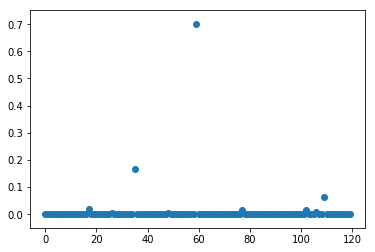

In [451]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib

plt.scatter(range(120), raw_valid_probs[5])
plt.show()

In [454]:
len(np.where(np.array(raw_valid_probs[5]) < 0.2)[0])

119

The next what should be done its clear results

In [42]:
def get_max_prob_per_item(probs):
    max_probs = []
    for prob in probs:
        max_probs.append(np.amax(prob))
    return max_probs

In [703]:
max_probs = get_max_prob_per_item(raw_valid_probs)

print np.amin(max_probs)
print len(raw_valid_probs)
len(np.where(np.array(max_probs) < 0.5)[0])

0.0831302
2000


461

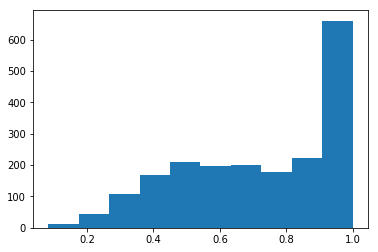

In [704]:
plt.hist(max_probs)
plt.show()

In [609]:
from keras.preprocessing import image

def plots_idx(idx, image_path=valid_path, filenames=val_filenames, titles=None):
    plots([image.load_img(image_path + filenames[i]) for i in idx], titles=titles)

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')    
    
#Number of images to view for each visualization task
n_view = 4

** #1.a Now lets look on a few correct labels where we highly confident (0.6) in prediction at random **

Found 857 correct labels


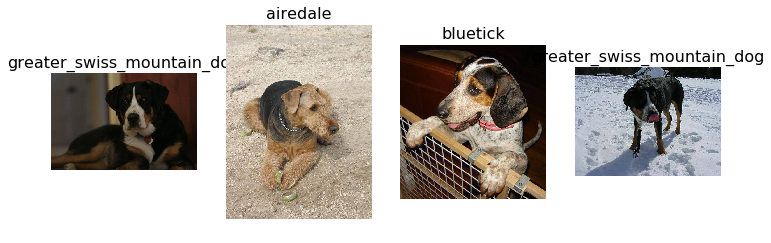

In [610]:
true_values_index = np.argmax(val_labels, axis=1)
predicted_values_index = np.argmax(raw_valid_probs, axis=1)

highly_confident = (np.max(raw_valid_probs, axis=1) > 0.6)

correct = np.where(highly_confident & (true_values_index==predicted_values_index))[0]
print "Found %d correct labels" % len(correct)
idx = np.random.permutation(correct)[:n_view]
plots_idx(idx, titles=[breed_from_path(val_filenames[index]) for index in idx])

** 1.b Lets look on a few correct labels but we are not confident (less that 0.6) in prediction at random **

Found 180 correct labels
[ 356  364 1464 1928]


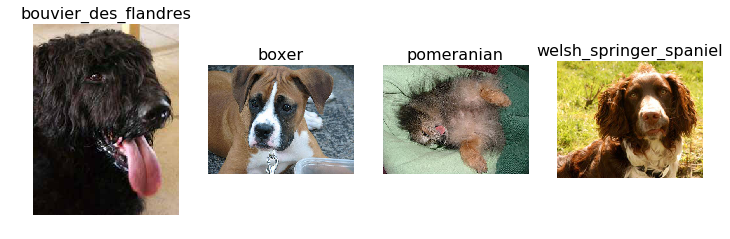

In [605]:
confidence = (np.max(raw_valid_probs, axis=1) <= 0.6)

correct = np.where(confidence & (true_values_index==predicted_values_index))[0]
print "Found %d correct labels" % len(correct)
idx = np.random.permutation(correct)[:n_view]
plots_idx(idx, titles=[breed_from_path(val_filenames[index]) for index in idx])

** #2. A few incorrect labels at random **

Found 963 incorrect labels
[1697  774 1268 1809]


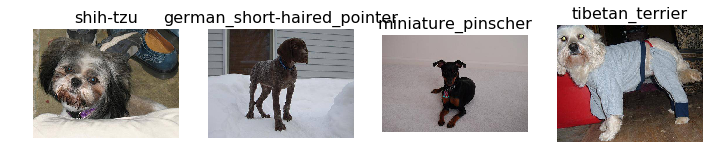

In [561]:
incorrect = np.where(np.argmax(val_labels, axis=1)!=np.argmax(raw_valid_probs, axis=1))[0]
print "Found %d incorrect labels" % len(incorrect)
idx = np.random.permutation(incorrect)[:n_view]
plots_idx(idx, titles=[breed_from_path(val_filenames[index]) for index in idx])

In [35]:
def prepare_predictions(pred_probs):
    prepared_result = []
    max_probs = get_max_prob_per_item(pred_probs)
    for row, max_prob in zip(pred_probs, max_probs):
        prepared_result.append(np.vectorize(lambda prob: prob if prob == max_prob else 0.0)(row))
    return prepared_result

In [143]:
index = 19

breed = breed_from_path(val_filenames[index])
print val_class_indices[breed]
print breed
max_prob_predicted_index = np.argmax(probs[index])
print max_prob_predicted_index
print probs[index][max_prob_predicted_index]

0
affenpinscher
0
0.969273


In [127]:
gen = image.ImageDataGenerator()
test_batches = gen.flow_from_directory(DATA_HOME_DIR + "test", target_size=target_size, batch_size=batch_size)

Found 10357 images belonging to 2 classes.


In [229]:
test_probs = model.predict_generator(test_batches, steps=(test_batches.n / batch_size + 1))

In [38]:
def get_ids(filenames):
    return np.vectorize(lambda filename: filename[-36:-4])(filenames)

In [39]:
test_ids = get_ids(test_batches.filenames)
len(test_ids)

10357

In [40]:
header = sorted(val_class_indices.keys())
header.insert(0, "id")
header = ','.join(header)

In [232]:
result = np.c_[test_ids, np.clip(test_probs, 0.05, 0.9)]

In [78]:
result[1:2]

array([['00102ee9d8eb90812350685311fe5890', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0.10000000149', '0.10000000149', '0.10000000149',
        '0.10000000149', '0

In [211]:
print len(result[2])
len(sorted(val_class_indices.keys()))

121


120

In [233]:
np.savetxt('result_200+epoch_valid_10%_InceptionResNetV2_clip.csv', result, delimiter=',', header=header, comments="", fmt='%s')

In [46]:
cd ..

/home/denys/projects/ml-models/kaggle/dog-breed-identification/data


In [678]:
from IPython.display import FileLink
FileLink("/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/result_finetune_only_max_1_51_epoch.csv")

/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/result_finetune_only_max_1.csv

In [131]:
sample_df = pd.read_csv("../data/sample_submission.csv")
sample_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [125]:
sample_df

labels.csv      results/               sample_submission.csv.zip  train/
labels.csv.zip  sample/                test/                      train.zip
models/         sample_submission.csv  test.zip                   valid/


In [55]:
val_filenames = val_batches.filenames
train_filenames = batches.filenames